---
딥러닝 과제 2

IT 공학과 2214224 서지은

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader
import time
import psutil
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

---
# 실습 과제 1

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [ ]:
# Function to measure memory usage
def measure_memory_usage(model):
    memory_allocated = torch.cuda.memory_allocated() / (1024 * 1024)  # in megabytes
    return memory_allocated

# Function to count model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Function to calculate accuracy
def calculate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data in data_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

# Function to calculate loss
def calculate_loss(model, data_loader):
    model.eval()
    loss_val = 0.0
    total_samples = 0

    with torch.no_grad():
        for data in data_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_val += loss.item() * labels.size(0)
            total_samples += labels.size(0)

    return loss_val / total_samples

# Function to measure inference time
def measure_inference_time(model, data_loader):
    model.eval()
    total_time = 0
    num_samples = 0

    with torch.no_grad():
        for data in data_loader:
            images, labels = data[0].to(device), data[1].to(device)

            torch.cuda.synchronize()
            start_time = torch.cuda.Event(enable_timing=True)
            end_time = torch.cuda.Event(enable_timing=True)

            start_time.record()
            outputs = model(images)
            end_time.record()

            torch.cuda.synchronize()
            inference_time = start_time.elapsed_time(end_time)
            total_time += inference_time
            num_samples += labels.size(0)

    return total_time / num_samples  # Average inference time per sample


## CNN without Dropout

In [ ]:
class NetWithoutDropOut(nn.Module):
    def __init__(self):
        super(NetWithoutDropOut, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        output = nn.functional.log_softmax(x, dim=1)
        return output

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net_no_dropout = NetWithoutDropOut().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_no_dropout.parameters(), lr=0.001)

train_loss_no_dropout = []
test_loss_no_dropout = []
train_accuracy_no_dropout = []
test_accuracy_no_dropout = []

for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net_no_dropout(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 200 == 199:
            train_loss = running_loss / 200
            train_loss_no_dropout.append(train_loss)
            train_accuracy = calculate_accuracy(net_no_dropout, trainloader)
            train_accuracy_no_dropout.append(train_accuracy)
            test_loss = calculate_loss(net_no_dropout, testloader)
            test_loss_no_dropout.append(test_loss)
            test_accuracy = calculate_accuracy(net_no_dropout, testloader)
            test_accuracy_no_dropout.append(test_accuracy)

            print(f'Epoch {epoch + 1}, Batch {i + 1}, Train Loss: {train_loss:.3f}, Train Acc: {train_accuracy:.3f}, Test Loss: {test_loss:.3f}, Test Acc: {test_accuracy:.3f}')
            running_loss = 0.0


# Calculate and print model parameters
num_parameters = count_parameters(net_no_dropout)
print(f'Number of model parameters: {num_parameters}')

# Measure and print inference time
inference_time = measure_inference_time(net_no_dropout, testloader)
print(f'Average inference time per sample: {inference_time:.2f} ms')

# Measure and print memory usage
memory_usage = measure_memory_usage(net_no_dropout)
print(f'Memory usage: {memory_usage:.2f} MB')

print('Finished Training')


Epoch 1, Batch 200, Train Loss: 0.341, Train Acc: 0.967, Test Loss: 0.098, Test Acc: 0.970
Epoch 1, Batch 400, Train Loss: 0.097, Train Acc: 0.978, Test Loss: 0.072, Test Acc: 0.976
Epoch 1, Batch 600, Train Loss: 0.068, Train Acc: 0.985, Test Loss: 0.049, Test Acc: 0.984
Epoch 1, Batch 800, Train Loss: 0.067, Train Acc: 0.987, Test Loss: 0.046, Test Acc: 0.986
Epoch 2, Batch 200, Train Loss: 0.040, Train Acc: 0.987, Test Loss: 0.045, Test Acc: 0.983
Epoch 2, Batch 400, Train Loss: 0.042, Train Acc: 0.988, Test Loss: 0.052, Test Acc: 0.983
Epoch 2, Batch 600, Train Loss: 0.041, Train Acc: 0.988, Test Loss: 0.046, Test Acc: 0.985
Epoch 2, Batch 800, Train Loss: 0.031, Train Acc: 0.993, Test Loss: 0.040, Test Acc: 0.987
Epoch 3, Batch 200, Train Loss: 0.024, Train Acc: 0.995, Test Loss: 0.033, Test Acc: 0.990
Epoch 3, Batch 400, Train Loss: 0.025, Train Acc: 0.994, Test Loss: 0.038, Test Acc: 0.989
Epoch 3, Batch 600, Train Loss: 0.025, Train Acc: 0.996, Test Loss: 0.033, Test Acc: 0.989

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        # images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net_no_dropout(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10,000 test images: {100 * correct / total}%')

Accuracy of the network on the 10,000 test images: 98.82%


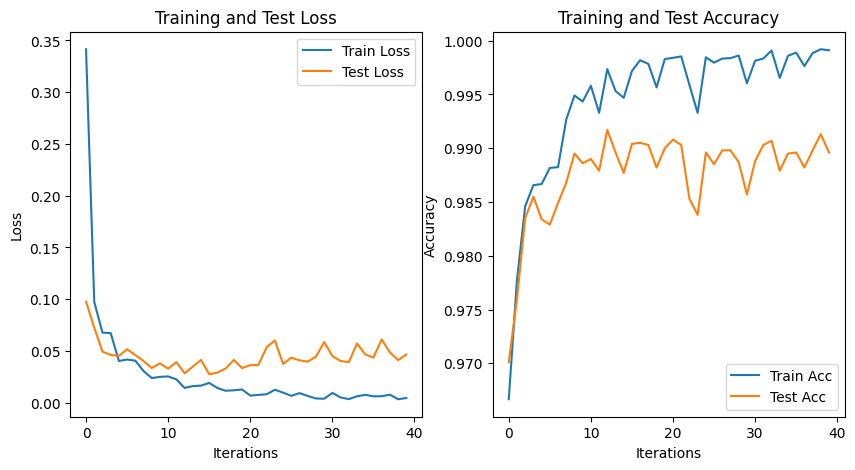

In [ ]:
import matplotlib.pyplot as plt
# Plotting
plt.figure(figsize=(10, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_loss_no_dropout, label='Train Loss')
plt.plot(test_loss_no_dropout, label='Test Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_no_dropout, label='Train Acc')
plt.plot(test_accuracy_no_dropout, label='Test Acc')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

plt.show()


기존의 Dropout 사용 모델

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = nn.functional.log_softmax(x, dim=1)
        return output

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net_with_dropout = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_with_dropout.parameters(), lr=0.001)

train_loss_with_dropout = []
test_loss_with_dropout = []
train_accuracy_with_dropout = []
test_accuracy_with_dropout = []


for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net_with_dropout(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 200 == 199:
            train_loss = running_loss / 200
            train_loss_with_dropout.append(train_loss)
            train_accuracy = calculate_accuracy(net_with_dropout, trainloader)
            train_accuracy_with_dropout.append(train_accuracy)
            test_loss = calculate_loss(net_with_dropout, testloader)
            test_loss_with_dropout.append(test_loss)
            test_accuracy = calculate_accuracy(net_with_dropout, testloader)
            test_accuracy_with_dropout.append(test_accuracy)

            print(f'Epoch {epoch + 1}, Batch {i + 1}, Train Loss: {train_loss:.3f}, Train Acc: {train_accuracy:.3f}, Test Loss: {test_loss:.3f}, Test Acc: {test_accuracy:.3f}')
            running_loss = 0.0

# Calculate and print model parameters
num_parameters = count_parameters(net_with_dropout)
print(f'Number of model parameters: {num_parameters}')

# Measure and print inference time
inference_time = measure_inference_time(net_with_dropout, testloader)
print(f'Average inference time per sample: {inference_time:.2f} ms')

# Measure and print memory usage
memory_usage = measure_memory_usage(net_with_dropout)
print(f'Memory usage: {memory_usage:.2f} MB')

print('Finished Training')



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1, Batch 200, Train Loss: 0.534, Train Acc: 0.962, Test Loss: 0.111, Test Acc: 0.968
Epoch 1, Batch 400, Train Loss: 0.099, Train Acc: 0.980, Test Loss: 0.067, Test Acc: 0.978
Epoch 1, Batch 600, Train Loss: 0.074, Train Acc: 0.983, Test Loss: 0.059, Test Acc: 0.982
Epoch 1, Batch 800, Train Loss: 0.060, Train Acc: 0.989, Test Loss: 0.047, Test Acc: 0.985
Epoch 2, Batch 200, Train Loss: 0.037, Train Acc: 0.988, Test Loss: 0.046, Test Acc: 0.985
Epoch 2, Batch 400, Train Loss: 0.042, Train Acc: 0.991, Test Loss: 0.045, Test Acc: 0.985
Epoch 2, Batch 600, Train Loss: 0.040, Train Acc: 0.992, Test Loss: 0.043, Test Acc: 0.986
Epoch 2, Batch 800, Train Loss: 0.036, Train Acc: 0.993, Test Loss: 0.038, Test Acc: 0.987
Epoch 3, Batch 200, Train Loss: 0.017, Train Acc: 0.994, Test Loss: 0.046, Test Acc: 0.987
Epoch 3, Batch 400, Train Loss: 0.024, Train Acc: 0.993, Test Loss: 0.047, Test Acc: 0.986
Epoch 3, Batch 600, Train Loss: 0.022, Train Acc: 0.997, Test Loss: 0.034, Test Acc: 0.991

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        # images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net_with_dropout(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10,000 test images: {100 * correct / total}%')

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Accuracy of the network on the 10,000 test images: 98.9%


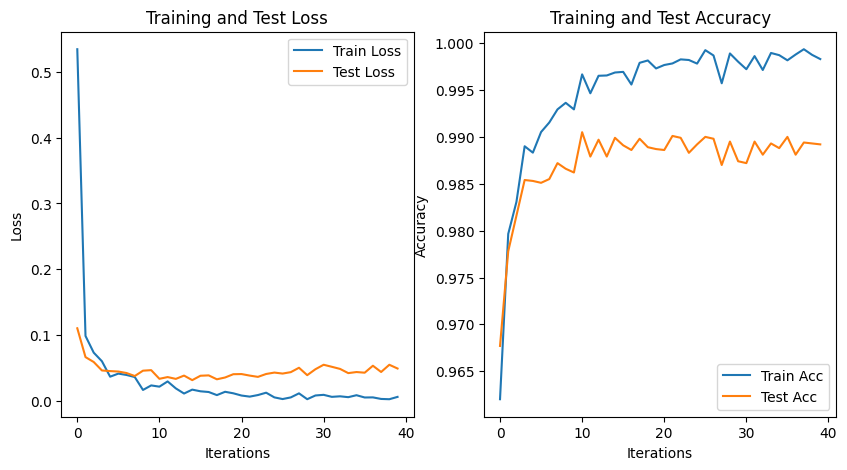

In [ ]:
import matplotlib.pyplot as plt
# Plotting
plt.figure(figsize=(10, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_loss_with_dropout, label='Train Loss')
plt.plot(test_loss_with_dropout, label='Test Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_with_dropout, label='Train Acc')
plt.plot(test_accuracy_with_dropout, label='Test Acc')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

plt.show()


## CNN with DropConnect

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

class DropConnect(nn.Module):
    def __init__(self, p=0.5):
        super(DropConnect, self).__init__()
        self.p = p

    def forward(self, x):
        if not self.training:
            return x

        batch_size = x.size(0)
        keep_prob = 1.0 - self.p
        mask = torch.rand(batch_size, *x.size()[1:], device=x.device) < keep_prob
        return x * mask / keep_prob

class NetWithDropConnect(nn.Module):
    def __init__(self):
        super(NetWithDropConnect, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = DropConnect(p=0.25)
        self.dropout2 = DropConnect(p=0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net_with_dropconnect = NetWithDropConnect().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_with_dropconnect.parameters(), lr=0.001)

train_loss_with_dropconnect = []
test_loss_with_dropconnect = []
train_accuracy_with_dropconnect = []
test_accuracy_with_dropconnect = []

for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = net_with_dropconnect(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 200 == 199:
            train_loss = running_loss / 200
            train_loss_with_dropconnect.append(train_loss)
            train_accuarcy = calculate_accuracy(net_with_dropconnect, trainloader)
            train_accuracy_with_dropconnect.append(train_accuracy)
            test_loss = calculate_loss(net_with_dropconnect, testloader)
            test_loss_with_dropconnect.append(test_loss)
            test_accuracy = calculate_accuracy(net_with_dropconnect, testloader)
            test_accuracy_with_dropconnect.append(test_accuracy)

            print(f'Epoch {epoch + 1}, Batch {i + 1}, Train Loss: {train_loss:.3f}, Train Acc: {train_accuracy:.3f}, Test Loss: {test_loss:.3f}, Test Acc: {test_accuracy:.3f}')
            running_loss = 0.0


# Calculate and print model parameters
num_parameters = count_parameters(net_with_dropconnect)
print(f'Number of model parameters: {num_parameters}')

# Measure and print inference time
inference_time = measure_inference_time(net_with_dropconnect, testloader)
print(f'Average inference time per sample: {inference_time:.2f} ms')

# Measure and print memory usage
memory_usage = measure_memory_usage(net_with_dropconnect)
print(f'Memory usage: {memory_usage:.2f} MB')

print('Finished Training')


Epoch 1, Batch 200, Train Loss: 0.496, Train Acc: 0.998, Test Loss: 0.107, Test Acc: 0.969
Epoch 1, Batch 400, Train Loss: 0.095, Train Acc: 0.998, Test Loss: 0.063, Test Acc: 0.981
Epoch 1, Batch 600, Train Loss: 0.064, Train Acc: 0.998, Test Loss: 0.054, Test Acc: 0.982
Epoch 1, Batch 800, Train Loss: 0.064, Train Acc: 0.998, Test Loss: 0.049, Test Acc: 0.984
Epoch 2, Batch 200, Train Loss: 0.038, Train Acc: 0.998, Test Loss: 0.043, Test Acc: 0.987
Epoch 2, Batch 400, Train Loss: 0.040, Train Acc: 0.998, Test Loss: 0.043, Test Acc: 0.986
Epoch 2, Batch 600, Train Loss: 0.035, Train Acc: 0.998, Test Loss: 0.046, Test Acc: 0.984
Epoch 2, Batch 800, Train Loss: 0.042, Train Acc: 0.998, Test Loss: 0.041, Test Acc: 0.987
Epoch 3, Batch 200, Train Loss: 0.021, Train Acc: 0.998, Test Loss: 0.039, Test Acc: 0.987
Epoch 3, Batch 400, Train Loss: 0.019, Train Acc: 0.998, Test Loss: 0.047, Test Acc: 0.986
Epoch 3, Batch 600, Train Loss: 0.026, Train Acc: 0.998, Test Loss: 0.038, Test Acc: 0.988

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:

        images, labels = data[0].to(device), data[1].to(device)
        outputs = net_with_dropconnect(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10,000 test images: {100 * correct / total}%')

Accuracy of the network on the 10,000 test images: 99.02%


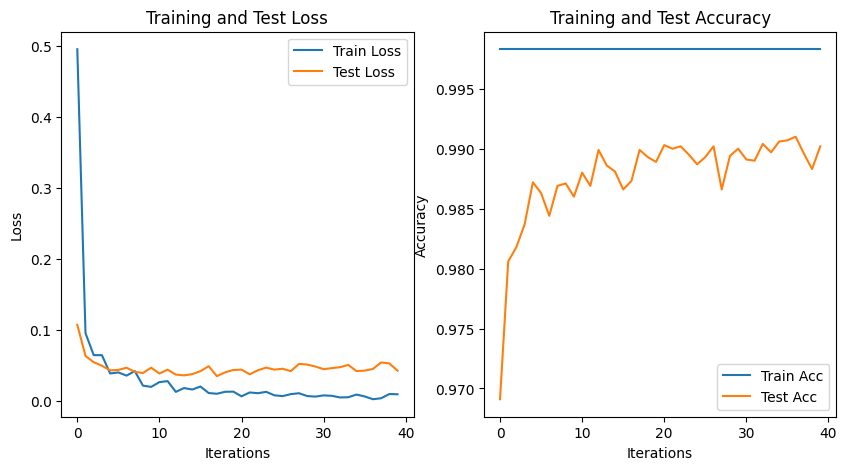

In [ ]:
import matplotlib.pyplot as plt
# Plotting
plt.figure(figsize=(10, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_loss_with_dropconnect, label='Train Loss')
plt.plot(test_loss_with_dropconnect, label='Test Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_with_dropconnect, label='Train Acc')
plt.plot(test_accuracy_with_dropconnect, label='Test Acc')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

plt.show()


정확도, 손실 비교

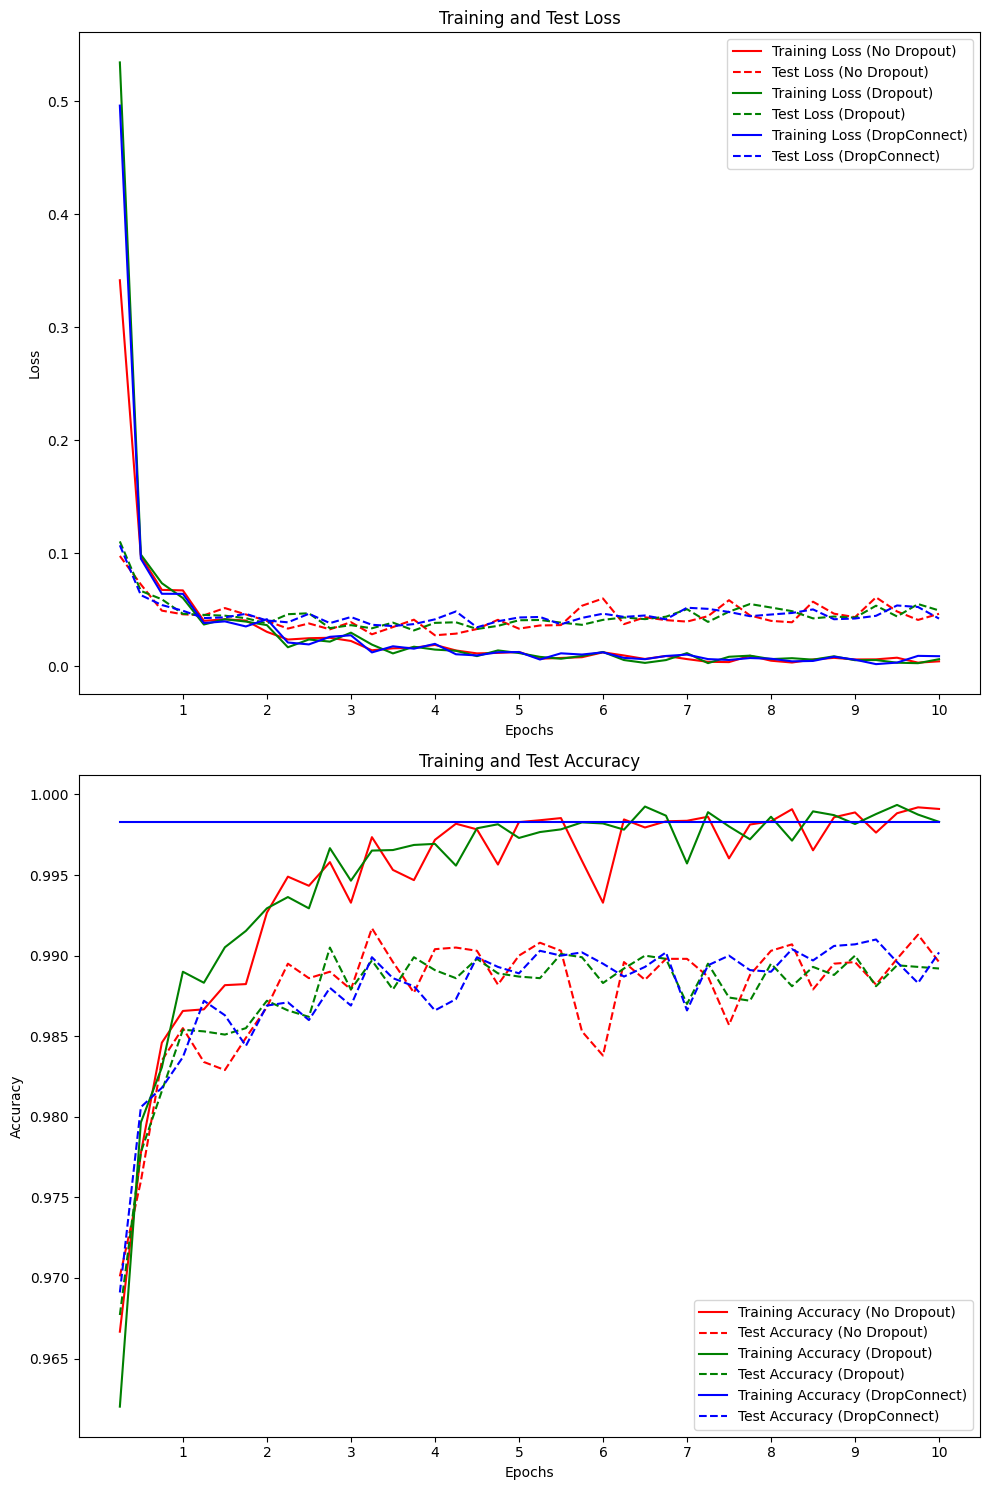

In [ ]:
import matplotlib.pyplot as plt

# Plotting
epochs = range(1, len(train_loss_no_dropout) + 1)

plt.figure(figsize=(10, 15))

# Plot loss
plt.subplot(2, 1, 1)
plt.plot(epochs, train_loss_no_dropout, 'r', label='Training Loss (No Dropout)')
plt.plot(epochs, test_loss_no_dropout, 'r--', label='Test Loss (No Dropout)')
plt.plot(epochs, train_loss_with_dropout, 'g', label='Training Loss (Dropout)')
plt.plot(epochs, test_loss_with_dropout, 'g--', label='Test Loss (Dropout)')
plt.plot(epochs, train_loss_with_dropconnect, 'b', label='Training Loss (DropConnect)')
plt.plot(epochs, test_loss_with_dropconnect, 'b--', label='Test Loss (DropConnect)')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(4, 41, 4), ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
plt.legend()

# Plot accuracy
plt.subplot(2, 1, 2)
plt.plot(epochs, train_accuracy_no_dropout, 'r', label='Training Accuracy (No Dropout)')
plt.plot(epochs, test_accuracy_no_dropout, 'r--', label='Test Accuracy (No Dropout)')
plt.plot(epochs, train_accuracy_with_dropout, 'g', label='Training Accuracy (Dropout)')
plt.plot(epochs, test_accuracy_with_dropout, 'g--', label='Test Accuracy (Dropout)')
plt.plot(epochs, train_accuracy_with_dropconnect, 'b', label='Training Accuracy (DropConnect)')
plt.plot(epochs, test_accuracy_with_dropconnect, 'b--', label='Test Accuracy (DropConnect)')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(4, 41, 4), ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
plt.legend()

plt.tight_layout()
plt.show()


---
# 실습 과제 2

## CNN With Dropout and 1M parameters

In [31]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Step 1: Load the CIFAR-10 dataset with transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Step 2: Define the CNN architecture without Dropout
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 128, 3, padding=1)
        self.conv2 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.global_avg_pool(x)
        x = x.view(-1, 256)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Step 3: Setup GPU usage
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net().to(device)

# Step 4: Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Step 5: Train the network
train_losses = []
train_accuracy = []

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

for epoch in range(10):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 200 == 199:
            avg_loss = running_loss / 200
            accuracy = 100 * correct / total
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {avg_loss:.3f}, Accuracy: {accuracy:.2f}%')
            train_losses.append(avg_loss)
            train_accuracy.append(accuracy)
            running_loss = 0.0
            correct = 0
            total = 0

print('Finished Training')

end.record()

torch.cuda.synchronize()

# Step 6: Evaluate the network on the test data
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10,000 test images: {100 * correct / total}%')

print('------------------------')
print('Memory Usage:')
print('Max Alloc:', round(torch.cuda.max_memory_allocated(0)/1024**3, 1), 'GB')
print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')
print('Runtime:',start.elapsed_time(end))


Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Batch 200, Loss: 2.017, Accuracy: 21.58%
Epoch 1, Batch 400, Loss: 1.720, Accuracy: 32.23%
Epoch 1, Batch 600, Loss: 1.599, Accuracy: 38.46%
Epoch 2, Batch 200, Loss: 1.337, Accuracy: 50.83%
Epoch 2, Batch 400, Loss: 1.253, Accuracy: 54.24%
Epoch 2, Batch 600, Loss: 1.179, Accuracy: 56.80%
Epoch 3, Batch 200, Loss: 1.054, Accuracy: 62.00%
Epoch 3, Batch 400, Loss: 0.995, Accuracy: 64.59%
Epoch 3, Batch 600, Loss: 0.993, Accuracy: 64.47%
Epoch 4, Batch 200, Loss: 0.887, Accuracy: 68.40%
Epoch 4, Batch 400, Loss: 0.877, Accuracy: 68.97%
Epoch 4, Batch 600, Loss: 0.859, Accuracy: 69.34%
Epoch 5, Batch 200, Loss: 0.782, Accuracy: 72.13%
Epoch 5, Batch 400, Loss: 0.767, Accuracy: 72.69%
Epoch 5, Batch 600, Loss: 0.753, Accuracy: 73.27%
Epoch 6, Batch 200, Loss: 0.692, Accuracy: 75.11%
Epoch 6, Batch 400, Loss: 0.689, Accuracy: 75.85%
Epoch 6, Batch 600, Loss: 0.682, Accuracy: 75.70%
Epoch 7, Batch 200, Loss

```
Epoch 1, Batch 200, Loss: 2.017, Accuracy: 21.58%
Epoch 1, Batch 400, Loss: 1.720, Accuracy: 32.23%
Epoch 1, Batch 600, Loss: 1.599, Accuracy: 38.46%
Epoch 2, Batch 200, Loss: 1.337, Accuracy: 50.83%
Epoch 2, Batch 400, Loss: 1.253, Accuracy: 54.24%
Epoch 2, Batch 600, Loss: 1.179, Accuracy: 56.80%
Epoch 3, Batch 200, Loss: 1.054, Accuracy: 62.00%
Epoch 3, Batch 400, Loss: 0.995, Accuracy: 64.59%
Epoch 3, Batch 600, Loss: 0.993, Accuracy: 64.47%
Epoch 4, Batch 200, Loss: 0.887, Accuracy: 68.40%
Epoch 4, Batch 400, Loss: 0.877, Accuracy: 68.97%
Epoch 4, Batch 600, Loss: 0.859, Accuracy: 69.34%
Epoch 5, Batch 200, Loss: 0.782, Accuracy: 72.13%
Epoch 5, Batch 400, Loss: 0.767, Accuracy: 72.69%
Epoch 5, Batch 600, Loss: 0.753, Accuracy: 73.27%
Epoch 6, Batch 200, Loss: 0.692, Accuracy: 75.11%
Epoch 6, Batch 400, Loss: 0.689, Accuracy: 75.85%
Epoch 6, Batch 600, Loss: 0.682, Accuracy: 75.70%
Epoch 7, Batch 200, Loss: 0.622, Accuracy: 77.98%
Epoch 7, Batch 400, Loss: 0.608, Accuracy: 78.68%
Epoch 7, Batch 600, Loss: 0.604, Accuracy: 78.84%
Epoch 8, Batch 200, Loss: 0.533, Accuracy: 81.13%
Epoch 8, Batch 400, Loss: 0.552, Accuracy: 80.44%
Epoch 8, Batch 600, Loss: 0.552, Accuracy: 80.74%
Epoch 9, Batch 200, Loss: 0.482, Accuracy: 83.30%
Epoch 9, Batch 400, Loss: 0.495, Accuracy: 82.79%
Epoch 9, Batch 600, Loss: 0.492, Accuracy: 82.71%
Epoch 10, Batch 200, Loss: 0.433, Accuracy: 85.03%
Epoch 10, Batch 400, Loss: 0.441, Accuracy: 83.99%
Epoch 10, Batch 600, Loss: 0.433, Accuracy: 84.59%
Finished Training
Accuracy of the network on the 10,000 test images: 78.41%
------------------------
Memory Usage:
Max Alloc: 0.4 GB
Allocated: 0.0 GB
Cached:    0.5 GB
Runtime: 292899.40625
```

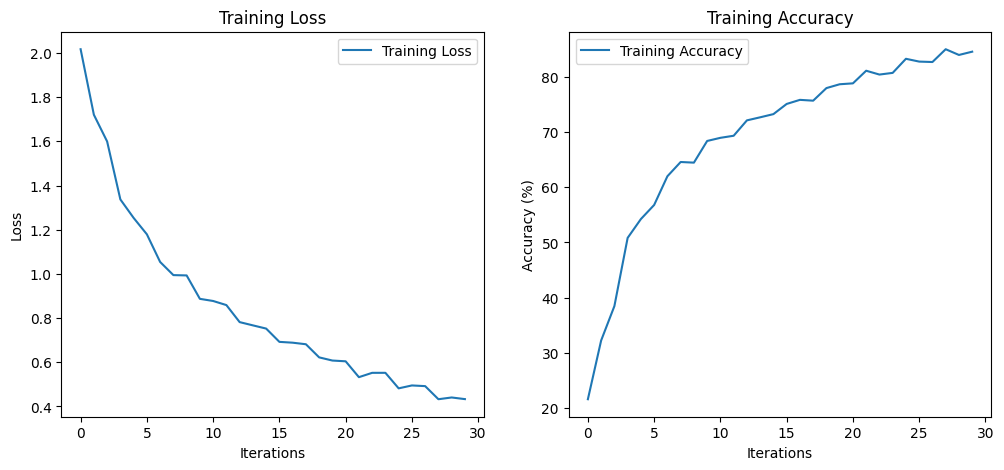

In [34]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


In [35]:
# prompt: count the total number of learnable parameters

total_params = sum(p.numel() for p in net.parameters())
print(f"Total Parameters: {total_params/1000} k")


Total Parameters: 1070.602 k


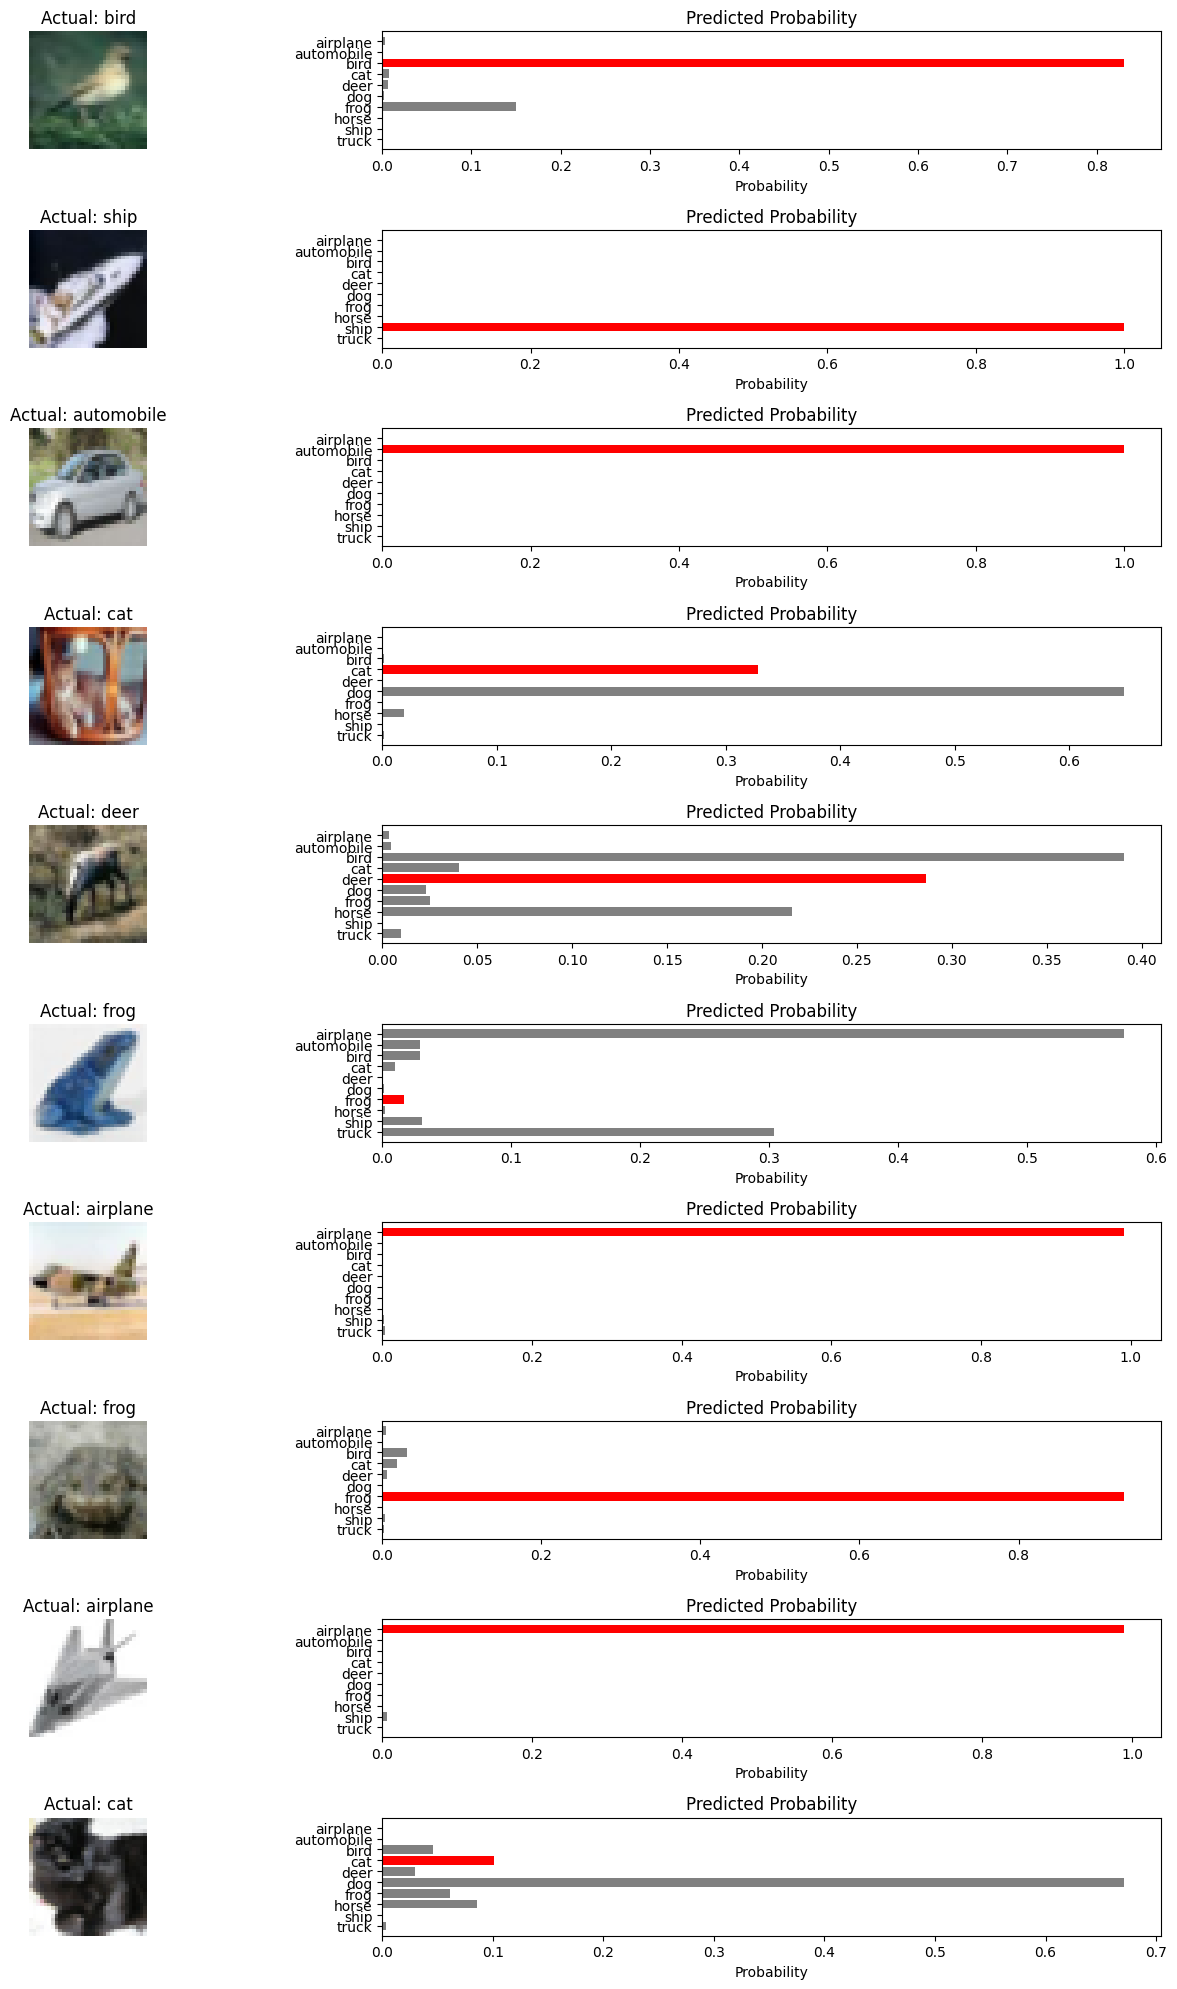

In [36]:
# Display the images along with their predicted classes and probabilities
num_images_to_display = 10
random_indices = np.random.choice(len(testset), num_images_to_display, replace=False)

# Function to get class labels from CIFAR-10 dataset
def get_class_labels():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Get class labels
class_labels = get_class_labels()


plt.figure(figsize=(15, 20))
for i, idx in enumerate(random_indices):
    image, label = testset[idx]
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to GPU if available
    output = net(image)
    probabilities = F.softmax(output, dim=1)[0]  # Compute softmax probabilities

    plt.subplot(num_images_to_display, 2, 2*i + 1)
    plt.imshow(image.squeeze().cpu().permute(1, 2, 0) * 0.5 + 0.5)  # Unnormalize and move to CPU for display
    plt.title(f'Actual: {class_labels[label]}')
    plt.axis('off')

    plt.subplot(num_images_to_display, 2, 2*i + 2)
    plt.barh(range(10), probabilities.cpu().detach().numpy(), tick_label=class_labels, color='gray')
    plt.barh(label, probabilities[label].cpu().detach().numpy(), color='red')
    plt.title('Predicted Probability')
    plt.xlabel('Probability')
    plt.gca().invert_yaxis()  # Invert y-axis to match class labels order
plt.tight_layout()
plt.show()


## CNN With GAP and 1M paramters

In [27]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Step 1: Load the CIFAR-10 dataset with transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Step 2: Define the CNN architecture with Dropout instead of BatchNorm
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 128, 3, padding=1)
        self.conv2 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
        self.dropout = nn.Dropout(0.5)  # Dropout layer with dropout probability of 0.5
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout(x)  # Apply dropout
        x = self.global_avg_pool(x)
        x = x.view(-1, 256)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Step 3: Setup GPU usage
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net().to(device)

# Step 4: Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Step 5: Train the network
train_losses = []
train_accuracy = []

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

for epoch in range(10):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 200 == 199:
            avg_loss = running_loss / 200
            accuracy = 100 * correct / total
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {avg_loss:.3f}, Accuracy: {accuracy:.2f}%')
            train_losses.append(avg_loss)
            train_accuracy.append(accuracy)
            running_loss = 0.0
            correct = 0
            total = 0

print('Finished Training')

end.record()

torch.cuda.synchronize()

# Step 6: Evaluate the network on the test data
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10,000 test images: {100 * correct / total}%')


print('------------------------')
print('Memory Usage:')
print('Max Alloc:', round(torch.cuda.max_memory_allocated(0)/1024**3, 1), 'GB')
print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')
print('Runtime:',start.elapsed_time(end))


Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Batch 200, Loss: 1.997, Accuracy: 22.45%
Epoch 1, Batch 400, Loss: 1.757, Accuracy: 31.61%
Epoch 1, Batch 600, Loss: 1.592, Accuracy: 39.09%
Epoch 2, Batch 200, Loss: 1.340, Accuracy: 50.28%
Epoch 2, Batch 400, Loss: 1.264, Accuracy: 54.12%
Epoch 2, Batch 600, Loss: 1.173, Accuracy: 56.70%
Epoch 3, Batch 200, Loss: 1.089, Accuracy: 60.29%
Epoch 3, Batch 400, Loss: 1.047, Accuracy: 62.63%
Epoch 3, Batch 600, Loss: 1.008, Accuracy: 63.90%
Epoch 4, Batch 200, Loss: 0.942, Accuracy: 65.99%
Epoch 4, Batch 400, Loss: 0.923, Accuracy: 66.88%
Epoch 4, Batch 600, Loss: 0.886, Accuracy: 68.70%
Epoch 5, Batch 200, Loss: 0.827, Accuracy: 69.89%
Epoch 5, Batch 400, Loss: 0.835, Accuracy: 70.44%
Epoch 5, Batch 600, Loss: 0.798, Accuracy: 71.90%
Epoch 6, Batch 200, Loss: 0.754, Accuracy: 73.64%
Epoch 6, Batch 400, Loss: 0.748, Accuracy: 73.53%
Epoch 6, Batch 600, Loss: 0.731, Accuracy: 74.17%
Epoch 7, Batch 200, Loss

```
Epoch 1, Batch 200, Loss: 1.997, Accuracy: 22.45%
Epoch 1, Batch 400, Loss: 1.757, Accuracy: 31.61%
Epoch 1, Batch 600, Loss: 1.592, Accuracy: 39.09%
Epoch 2, Batch 200, Loss: 1.340, Accuracy: 50.28%
Epoch 2, Batch 400, Loss: 1.264, Accuracy: 54.12%
Epoch 2, Batch 600, Loss: 1.173, Accuracy: 56.70%
Epoch 3, Batch 200, Loss: 1.089, Accuracy: 60.29%
Epoch 3, Batch 400, Loss: 1.047, Accuracy: 62.63%
Epoch 3, Batch 600, Loss: 1.008, Accuracy: 63.90%
Epoch 4, Batch 200, Loss: 0.942, Accuracy: 65.99%
Epoch 4, Batch 400, Loss: 0.923, Accuracy: 66.88%
Epoch 4, Batch 600, Loss: 0.886, Accuracy: 68.70%
Epoch 5, Batch 200, Loss: 0.827, Accuracy: 69.89%
Epoch 5, Batch 400, Loss: 0.835, Accuracy: 70.44%
Epoch 5, Batch 600, Loss: 0.798, Accuracy: 71.90%
Epoch 6, Batch 200, Loss: 0.754, Accuracy: 73.64%
Epoch 6, Batch 400, Loss: 0.748, Accuracy: 73.53%
Epoch 6, Batch 600, Loss: 0.731, Accuracy: 74.17%
Epoch 7, Batch 200, Loss: 0.679, Accuracy: 75.89%
Epoch 7, Batch 400, Loss: 0.692, Accuracy: 75.62%
Epoch 7, Batch 600, Loss: 0.675, Accuracy: 76.03%
Epoch 8, Batch 200, Loss: 0.639, Accuracy: 77.66%
Epoch 8, Batch 400, Loss: 0.628, Accuracy: 77.64%
Epoch 8, Batch 600, Loss: 0.640, Accuracy: 77.94%
Epoch 9, Batch 200, Loss: 0.581, Accuracy: 79.67%
Epoch 9, Batch 400, Loss: 0.600, Accuracy: 78.80%
Epoch 9, Batch 600, Loss: 0.578, Accuracy: 79.67%
Epoch 10, Batch 200, Loss: 0.532, Accuracy: 81.30%
Epoch 10, Batch 400, Loss: 0.548, Accuracy: 80.81%
Epoch 10, Batch 600, Loss: 0.526, Accuracy: 81.36%
Finished Training
Accuracy of the network on the 10,000 test images: 77.53%
------------------------
Memory Usage:
Max Alloc: 0.4 GB
Allocated: 0.0 GB
Cached:    0.5 GB
Runtime: 290283.46875
```

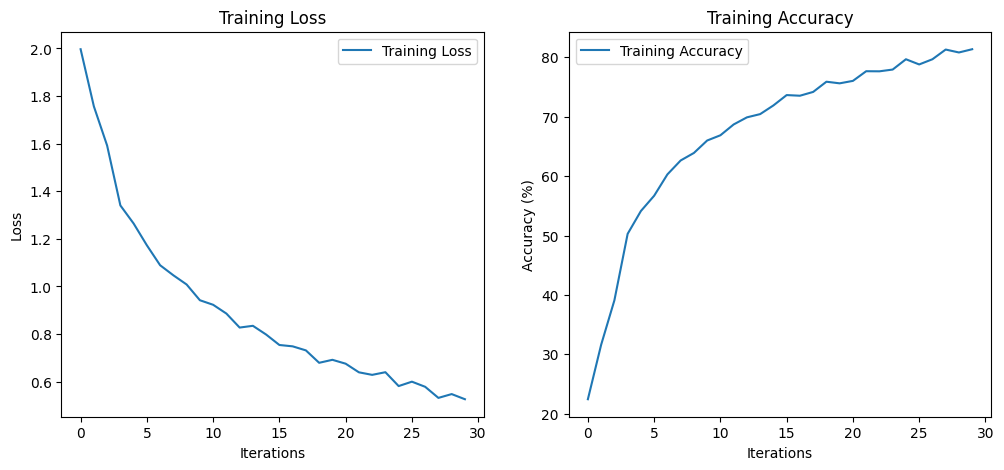

In [28]:
# Step 7: Plot the learning curves for accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


In [29]:
# prompt: count the total number of learnable parameters

total_params = sum(p.numel() for p in net.parameters())
print(f"Total Parameters: {total_params/1000} k")


Total Parameters: 1070.602 k


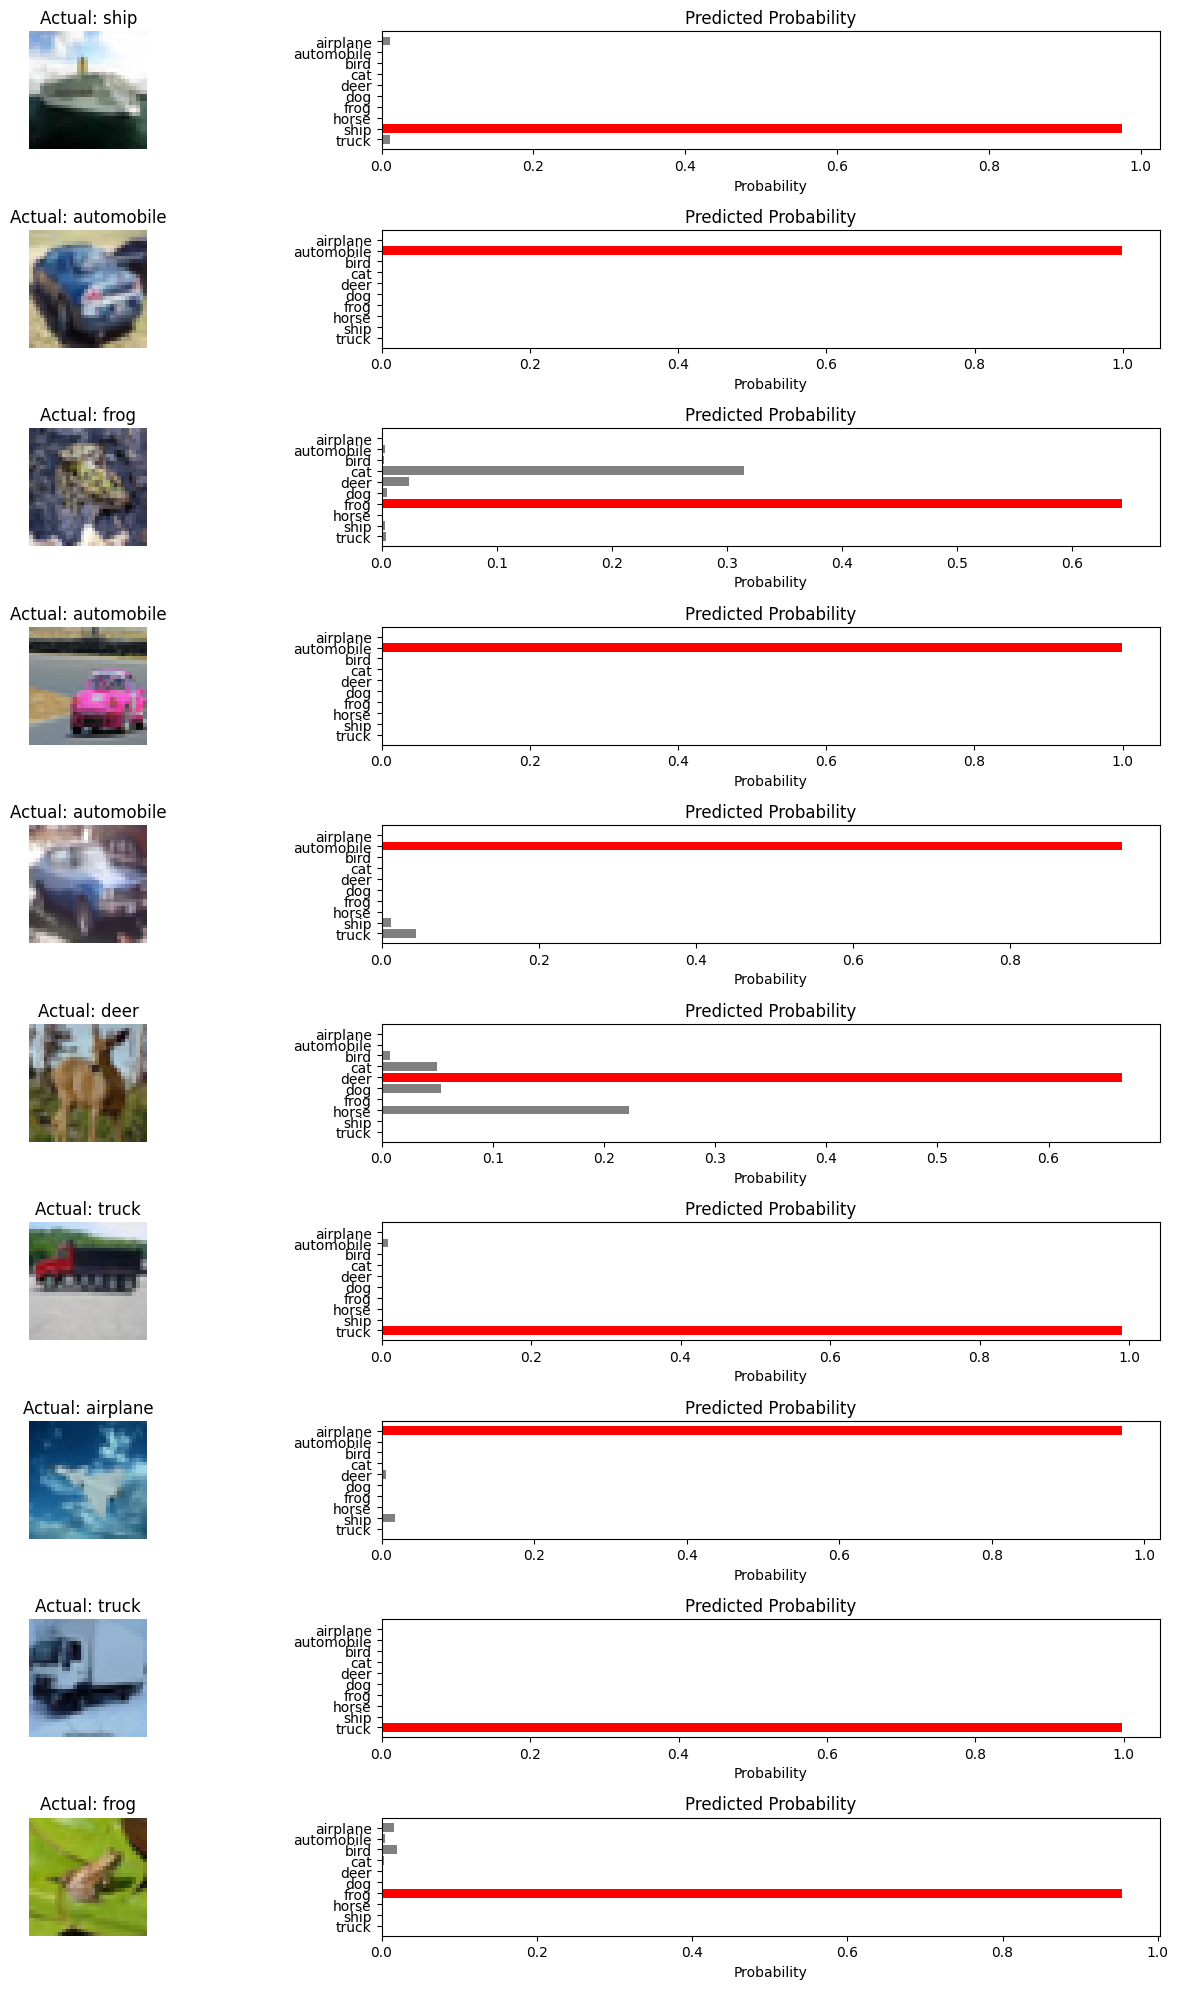

In [30]:
# Display the images along with their predicted classes and probabilities
num_images_to_display = 10
random_indices = np.random.choice(len(testset), num_images_to_display, replace=False)

# Function to get class labels from CIFAR-10 dataset
def get_class_labels():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Get class labels
class_labels = get_class_labels()


plt.figure(figsize=(15, 20))
for i, idx in enumerate(random_indices):
    image, label = testset[idx]
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to GPU if available
    output = net(image)
    probabilities = F.softmax(output, dim=1)[0]  # Compute softmax probabilities

    plt.subplot(num_images_to_display, 2, 2*i + 1)
    plt.imshow(image.squeeze().cpu().permute(1, 2, 0) * 0.5 + 0.5)  # Unnormalize and move to CPU for display
    plt.title(f'Actual: {class_labels[label]}')
    plt.axis('off')

    plt.subplot(num_images_to_display, 2, 2*i + 2)
    plt.barh(range(10), probabilities.cpu().detach().numpy(), tick_label=class_labels, color='gray')
    plt.barh(label, probabilities[label].cpu().detach().numpy(), color='red')
    plt.title('Predicted Probability')
    plt.xlabel('Probability')
    plt.gca().invert_yaxis()  # Invert y-axis to match class labels order
plt.tight_layout()
plt.show()


---
# 실습 과제 3

## with batch norm

In [16]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Step 1: Load the CIFAR-10 dataset with transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Step 2: Define the CNN architecture with Global Average Pooling
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 128, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.global_avg_pool(x)
        x = x.view(-1, 256)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Step 3: Setup GPU usage
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net().to(device)

# Step 4: Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Step 5: Train the network
train_losses = []
train_accuracy = []

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

for epoch in range(10):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 200 == 199:
            avg_loss = running_loss / 200
            accuracy = 100 * correct / total
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {avg_loss:.3f}, Accuracy: {accuracy:.2f}%')
            train_losses.append(avg_loss)
            train_accuracy.append(accuracy)
            running_loss = 0.0
            correct = 0
            total = 0

print('Finished Training')

end.record()

torch.cuda.synchronize()

# Step 6: Evaluate the network on the test data
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10,000 test images: {100 * correct / total}%')

print('------------------------')
print('Memory Usage:')
print('Max Alloc:', round(torch.cuda.max_memory_allocated(0)/1024**3, 1), 'GB')
print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')
print('Runtime:',start.elapsed_time(end))

Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Batch 200, Loss: 1.629, Accuracy: 38.68%
Epoch 1, Batch 400, Loss: 1.317, Accuracy: 51.27%
Epoch 1, Batch 600, Loss: 1.182, Accuracy: 57.57%
Epoch 2, Batch 200, Loss: 1.025, Accuracy: 63.22%
Epoch 2, Batch 400, Loss: 0.968, Accuracy: 65.64%
Epoch 2, Batch 600, Loss: 0.947, Accuracy: 65.94%
Epoch 3, Batch 200, Loss: 0.834, Accuracy: 70.91%
Epoch 3, Batch 400, Loss: 0.824, Accuracy: 71.18%
Epoch 3, Batch 600, Loss: 0.788, Accuracy: 71.79%
Epoch 4, Batch 200, Loss: 0.714, Accuracy: 75.05%
Epoch 4, Batch 400, Loss: 0.719, Accuracy: 74.55%
Epoch 4, Batch 600, Loss: 0.687, Accuracy: 75.79%
Epoch 5, Batch 200, Loss: 0.631, Accuracy: 77.59%
Epoch 5, Batch 400, Loss: 0.630, Accuracy: 78.08%
Epoch 5, Batch 600, Loss: 0.623, Accuracy: 78.30%
Epoch 6, Batch 200, Loss: 0.545, Accuracy: 80.98%
Epoch 6, Batch 400, Loss: 0.566, Accuracy: 80.55%
Epoch 6, Batch 600, Loss: 0.557, Accuracy: 80.59%
Epoch 7, Batch 200, Loss

/usr/local/lib/python3.10/dist-packages/torch/cuda/memory.py:440: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


```
Epoch 1, Batch 200, Loss: 1.629, Accuracy: 38.68%
Epoch 1, Batch 400, Loss: 1.317, Accuracy: 51.27%
Epoch 1, Batch 600, Loss: 1.182, Accuracy: 57.57%
Epoch 2, Batch 200, Loss: 1.025, Accuracy: 63.22%
Epoch 2, Batch 400, Loss: 0.968, Accuracy: 65.64%
Epoch 2, Batch 600, Loss: 0.947, Accuracy: 65.94%
Epoch 3, Batch 200, Loss: 0.834, Accuracy: 70.91%
Epoch 3, Batch 400, Loss: 0.824, Accuracy: 71.18%
Epoch 3, Batch 600, Loss: 0.788, Accuracy: 71.79%
Epoch 4, Batch 200, Loss: 0.714, Accuracy: 75.05%
Epoch 4, Batch 400, Loss: 0.719, Accuracy: 74.55%
Epoch 4, Batch 600, Loss: 0.687, Accuracy: 75.79%
Epoch 5, Batch 200, Loss: 0.631, Accuracy: 77.59%
Epoch 5, Batch 400, Loss: 0.630, Accuracy: 78.08%
Epoch 5, Batch 600, Loss: 0.623, Accuracy: 78.30%
Epoch 6, Batch 200, Loss: 0.545, Accuracy: 80.98%
Epoch 6, Batch 400, Loss: 0.566, Accuracy: 80.55%
Epoch 6, Batch 600, Loss: 0.557, Accuracy: 80.59%
Epoch 7, Batch 200, Loss: 0.487, Accuracy: 83.03%
Epoch 7, Batch 400, Loss: 0.496, Accuracy: 83.02%
Epoch 7, Batch 600, Loss: 0.498, Accuracy: 82.70%
Epoch 8, Batch 200, Loss: 0.435, Accuracy: 84.87%
Epoch 8, Batch 400, Loss: 0.456, Accuracy: 84.10%
Epoch 8, Batch 600, Loss: 0.453, Accuracy: 83.91%
Epoch 9, Batch 200, Loss: 0.390, Accuracy: 86.11%
Epoch 9, Batch 400, Loss: 0.407, Accuracy: 85.90%
Epoch 9, Batch 600, Loss: 0.393, Accuracy: 85.99%
Epoch 10, Batch 200, Loss: 0.347, Accuracy: 87.63%
Epoch 10, Batch 400, Loss: 0.349, Accuracy: 87.67%
Epoch 10, Batch 600, Loss: 0.383, Accuracy: 86.67%
Finished Training
Accuracy of the network on the 10,000 test images: 82.22%
------------------------
Memory Usage:
Max Alloc: 0.4 GB
Allocated: 0.0 GB
Cached:    0.5 GB
Runtime: 331299.0
```

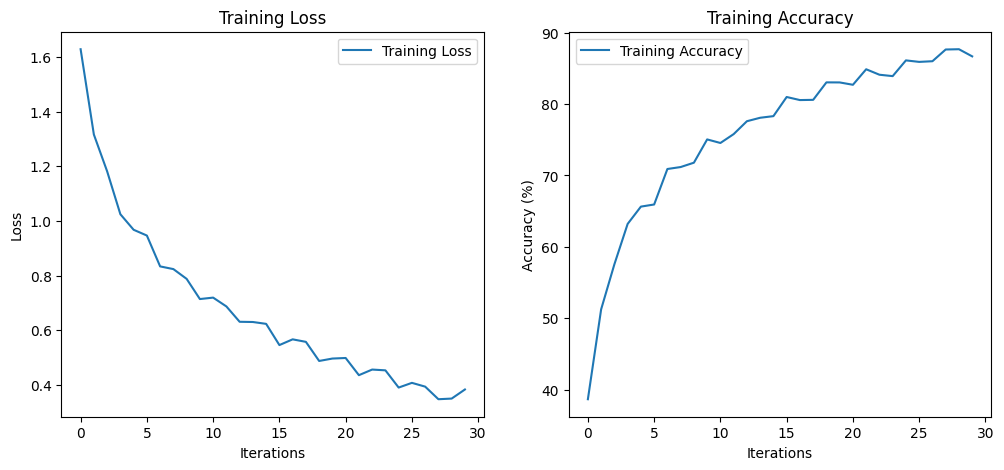

In [17]:
# Step 7: Plot the learning curves for accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


In [18]:
# prompt: count the total number of learnable parameters

total_params = sum(p.numel() for p in net.parameters())
print(f"Total Parameters: {total_params/1000} k")


Total Parameters: 1072.138 k


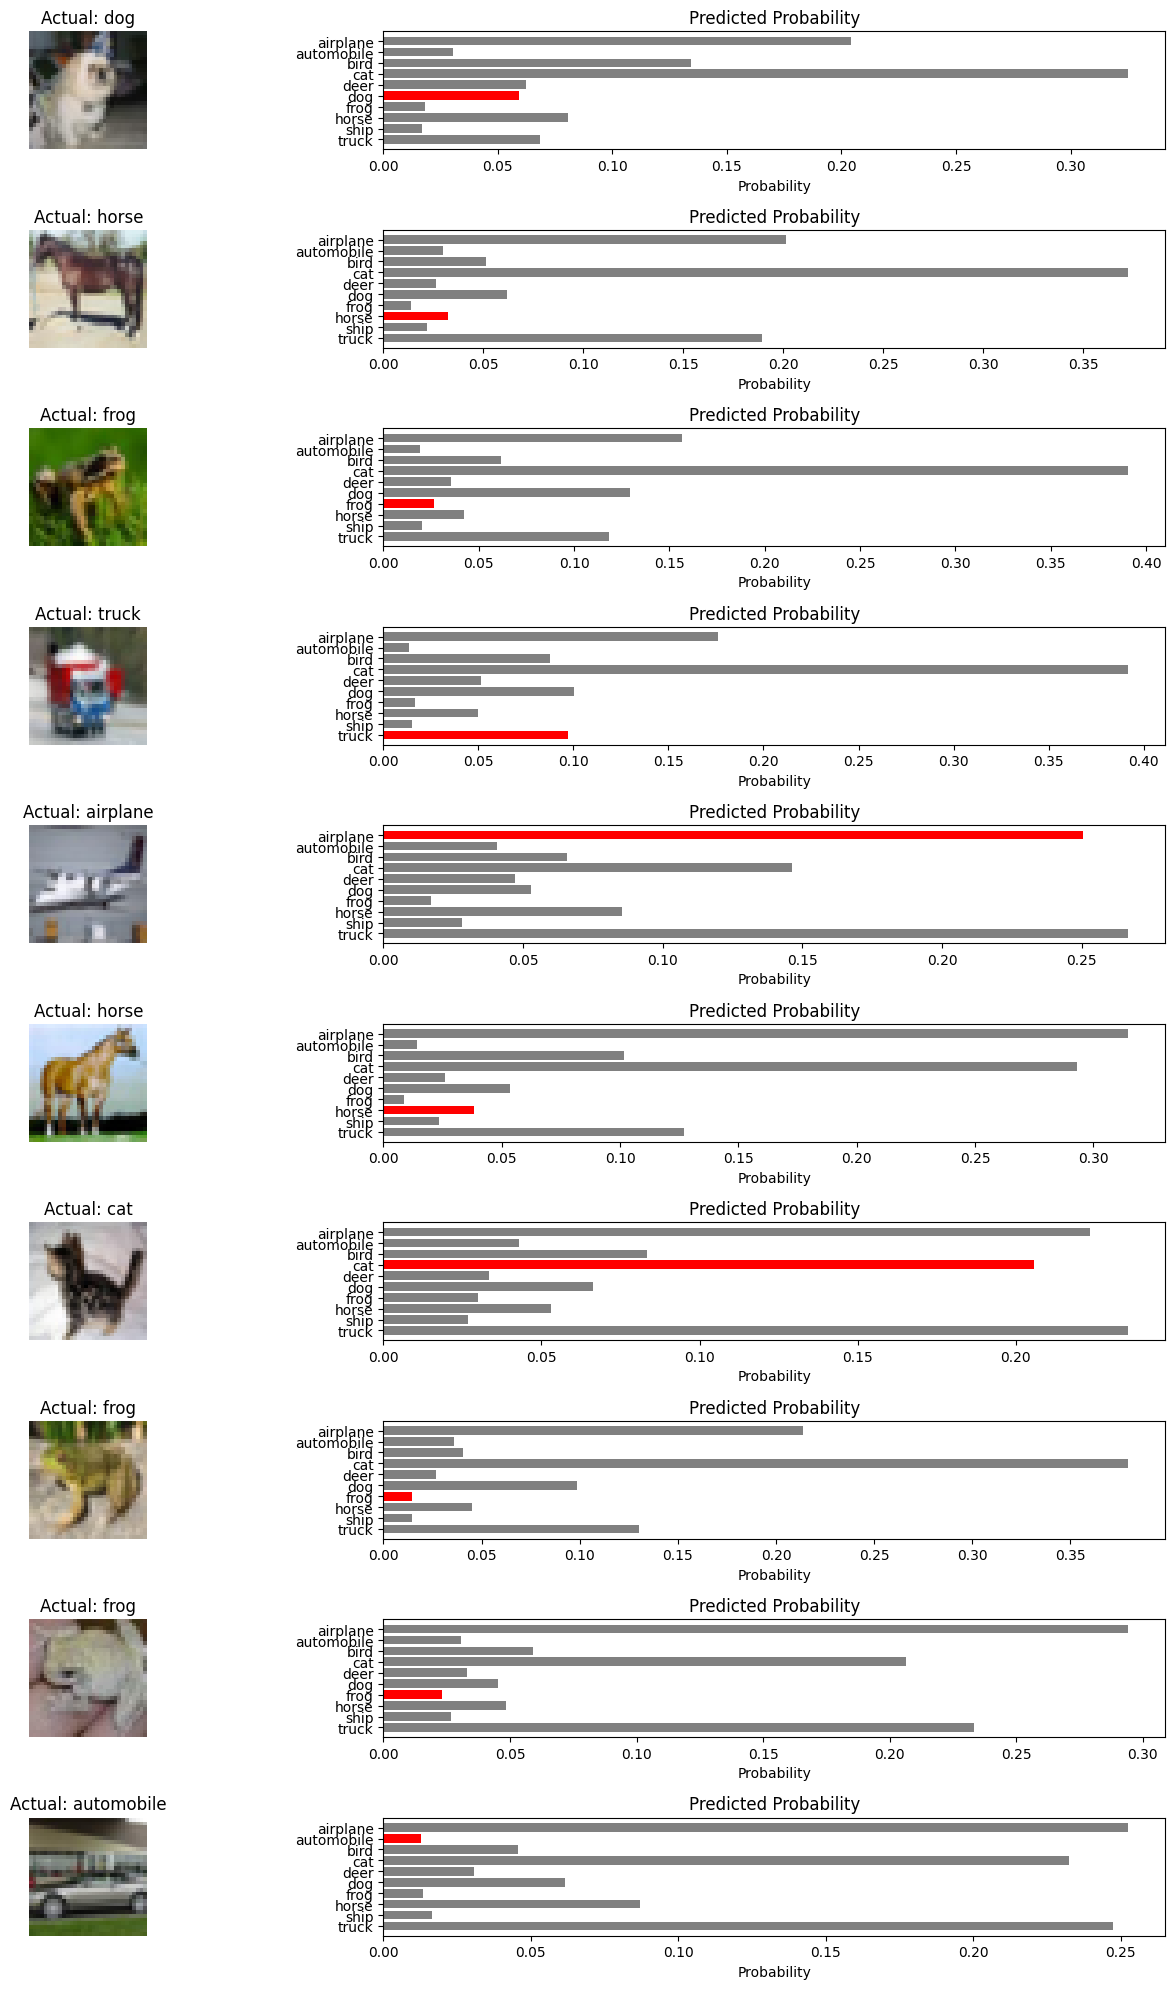

In [19]:
# Display the images along with their predicted classes and probabilities
num_images_to_display = 10
random_indices = np.random.choice(len(testset), num_images_to_display, replace=False)

# Function to get class labels from CIFAR-10 dataset
def get_class_labels():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Get class labels
class_labels = get_class_labels()


plt.figure(figsize=(15, 20))
for i, idx in enumerate(random_indices):
    image, label = testset[idx]
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to GPU if available
    output = net(image)
    probabilities = F.softmax(output, dim=1)[0]  # Compute softmax probabilities

    plt.subplot(num_images_to_display, 2, 2*i + 1)
    plt.imshow(image.squeeze().cpu().permute(1, 2, 0) * 0.5 + 0.5)  # Unnormalize and move to CPU for display
    plt.title(f'Actual: {class_labels[label]}')
    plt.axis('off')

    plt.subplot(num_images_to_display, 2, 2*i + 2)
    plt.barh(range(10), probabilities.cpu().detach().numpy(), tick_label=class_labels, color='gray')
    plt.barh(label, probabilities[label].cpu().detach().numpy(), color='red')
    plt.title('Predicted Probability')
    plt.xlabel('Probability')
    plt.gca().invert_yaxis()  # Invert y-axis to match class labels order
plt.tight_layout()
plt.show()


## without batch norm

In [20]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Step 1: Load the CIFAR-10 dataset with transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Step 2: Define the CNN architecture with Dropout instead of BatchNorm
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 128, 3, padding=1)
        self.conv2 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
        self.dropout = nn.Dropout(0.5)  # Dropout layer with dropout probability of 0.5
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout(x)  # Apply dropout
        x = self.global_avg_pool(x)
        x = x.view(-1, 256)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Step 3: Setup GPU usage
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net().to(device)

# Step 4: Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Step 5: Train the network
train_losses = []
train_accuracy = []


start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()


for epoch in range(10):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 200 == 199:
            avg_loss = running_loss / 200
            accuracy = 100 * correct / total
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {avg_loss:.3f}, Accuracy: {accuracy:.2f}%')
            train_losses.append(avg_loss)
            train_accuracy.append(accuracy)
            running_loss = 0.0
            correct = 0
            total = 0

print('Finished Training')

end.record()

torch.cuda.synchronize()

# Step 6: Evaluate the network on the test data
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10,000 test images: {100 * correct / total}%')


print('------------------------')
print('Memory Usage:')
print('Max Alloc:', round(torch.cuda.max_memory_allocated(0)/1024**3, 1), 'GB')
print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')
print('Runtime:',start.elapsed_time(end))


Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Batch 200, Loss: 1.935, Accuracy: 25.37%
Epoch 1, Batch 400, Loss: 1.735, Accuracy: 33.14%
Epoch 1, Batch 600, Loss: 1.505, Accuracy: 43.17%
Epoch 2, Batch 200, Loss: 1.286, Accuracy: 52.64%
Epoch 2, Batch 400, Loss: 1.215, Accuracy: 55.20%
Epoch 2, Batch 600, Loss: 1.165, Accuracy: 57.74%
Epoch 3, Batch 200, Loss: 1.047, Accuracy: 61.99%
Epoch 3, Batch 400, Loss: 1.010, Accuracy: 63.48%
Epoch 3, Batch 600, Loss: 0.959, Accuracy: 65.41%
Epoch 4, Batch 200, Loss: 0.889, Accuracy: 68.30%
Epoch 4, Batch 400, Loss: 0.877, Accuracy: 68.55%
Epoch 4, Batch 600, Loss: 0.853, Accuracy: 68.96%
Epoch 5, Batch 200, Loss: 0.794, Accuracy: 72.03%
Epoch 5, Batch 400, Loss: 0.777, Accuracy: 72.87%
Epoch 5, Batch 600, Loss: 0.759, Accuracy: 72.75%
Epoch 6, Batch 200, Loss: 0.706, Accuracy: 74.92%
Epoch 6, Batch 400, Loss: 0.713, Accuracy: 73.98%
Epoch 6, Batch 600, Loss: 0.701, Accuracy: 75.45%
Epoch 7, Batch 200, Loss

```
Epoch 1, Batch 200, Loss: 1.935, Accuracy: 25.37%
Epoch 1, Batch 400, Loss: 1.735, Accuracy: 33.14%
Epoch 1, Batch 600, Loss: 1.505, Accuracy: 43.17%
Epoch 2, Batch 200, Loss: 1.286, Accuracy: 52.64%
Epoch 2, Batch 400, Loss: 1.215, Accuracy: 55.20%
Epoch 2, Batch 600, Loss: 1.165, Accuracy: 57.74%
Epoch 3, Batch 200, Loss: 1.047, Accuracy: 61.99%
Epoch 3, Batch 400, Loss: 1.010, Accuracy: 63.48%
Epoch 3, Batch 600, Loss: 0.959, Accuracy: 65.41%
Epoch 4, Batch 200, Loss: 0.889, Accuracy: 68.30%
Epoch 4, Batch 400, Loss: 0.877, Accuracy: 68.55%
Epoch 4, Batch 600, Loss: 0.853, Accuracy: 68.96%
Epoch 5, Batch 200, Loss: 0.794, Accuracy: 72.03%
Epoch 5, Batch 400, Loss: 0.777, Accuracy: 72.87%
Epoch 5, Batch 600, Loss: 0.759, Accuracy: 72.75%
Epoch 6, Batch 200, Loss: 0.706, Accuracy: 74.92%
Epoch 6, Batch 400, Loss: 0.713, Accuracy: 73.98%
Epoch 6, Batch 600, Loss: 0.701, Accuracy: 75.45%
Epoch 7, Batch 200, Loss: 0.642, Accuracy: 77.16%
Epoch 7, Batch 400, Loss: 0.627, Accuracy: 77.94%
Epoch 7, Batch 600, Loss: 0.632, Accuracy: 77.78%
Epoch 8, Batch 200, Loss: 0.580, Accuracy: 79.49%
Epoch 8, Batch 400, Loss: 0.582, Accuracy: 79.84%
Epoch 8, Batch 600, Loss: 0.587, Accuracy: 79.51%
Epoch 9, Batch 200, Loss: 0.535, Accuracy: 81.24%
Epoch 9, Batch 400, Loss: 0.531, Accuracy: 81.28%
Epoch 9, Batch 600, Loss: 0.535, Accuracy: 81.29%
Epoch 10, Batch 200, Loss: 0.491, Accuracy: 82.90%
Epoch 10, Batch 400, Loss: 0.485, Accuracy: 82.77%
Epoch 10, Batch 600, Loss: 0.495, Accuracy: 82.62%
Finished Training
Accuracy of the network on the 10,000 test images: 77.75%
------------------------
Memory Usage:
Max Alloc: 0.4 GB
Allocated: 0.0 GB
Cached:    0.5 GB
Runtime: 302612.1875
```

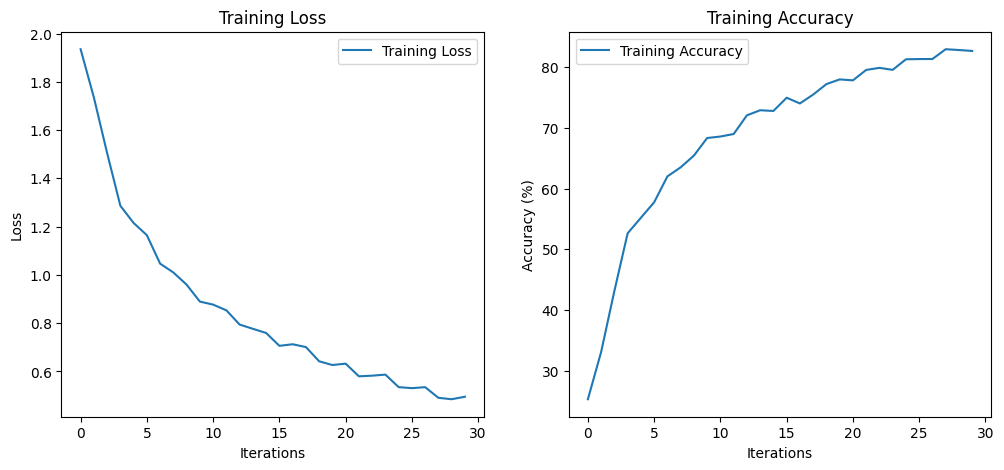

In [24]:
# Step 7: Plot the learning curves for accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


In [25]:
# prompt: count the total number of learnable parameters

total_params = sum(p.numel() for p in net.parameters())
print(f"Total Parameters: {total_params/1000} k")


Total Parameters: 1070.602 k


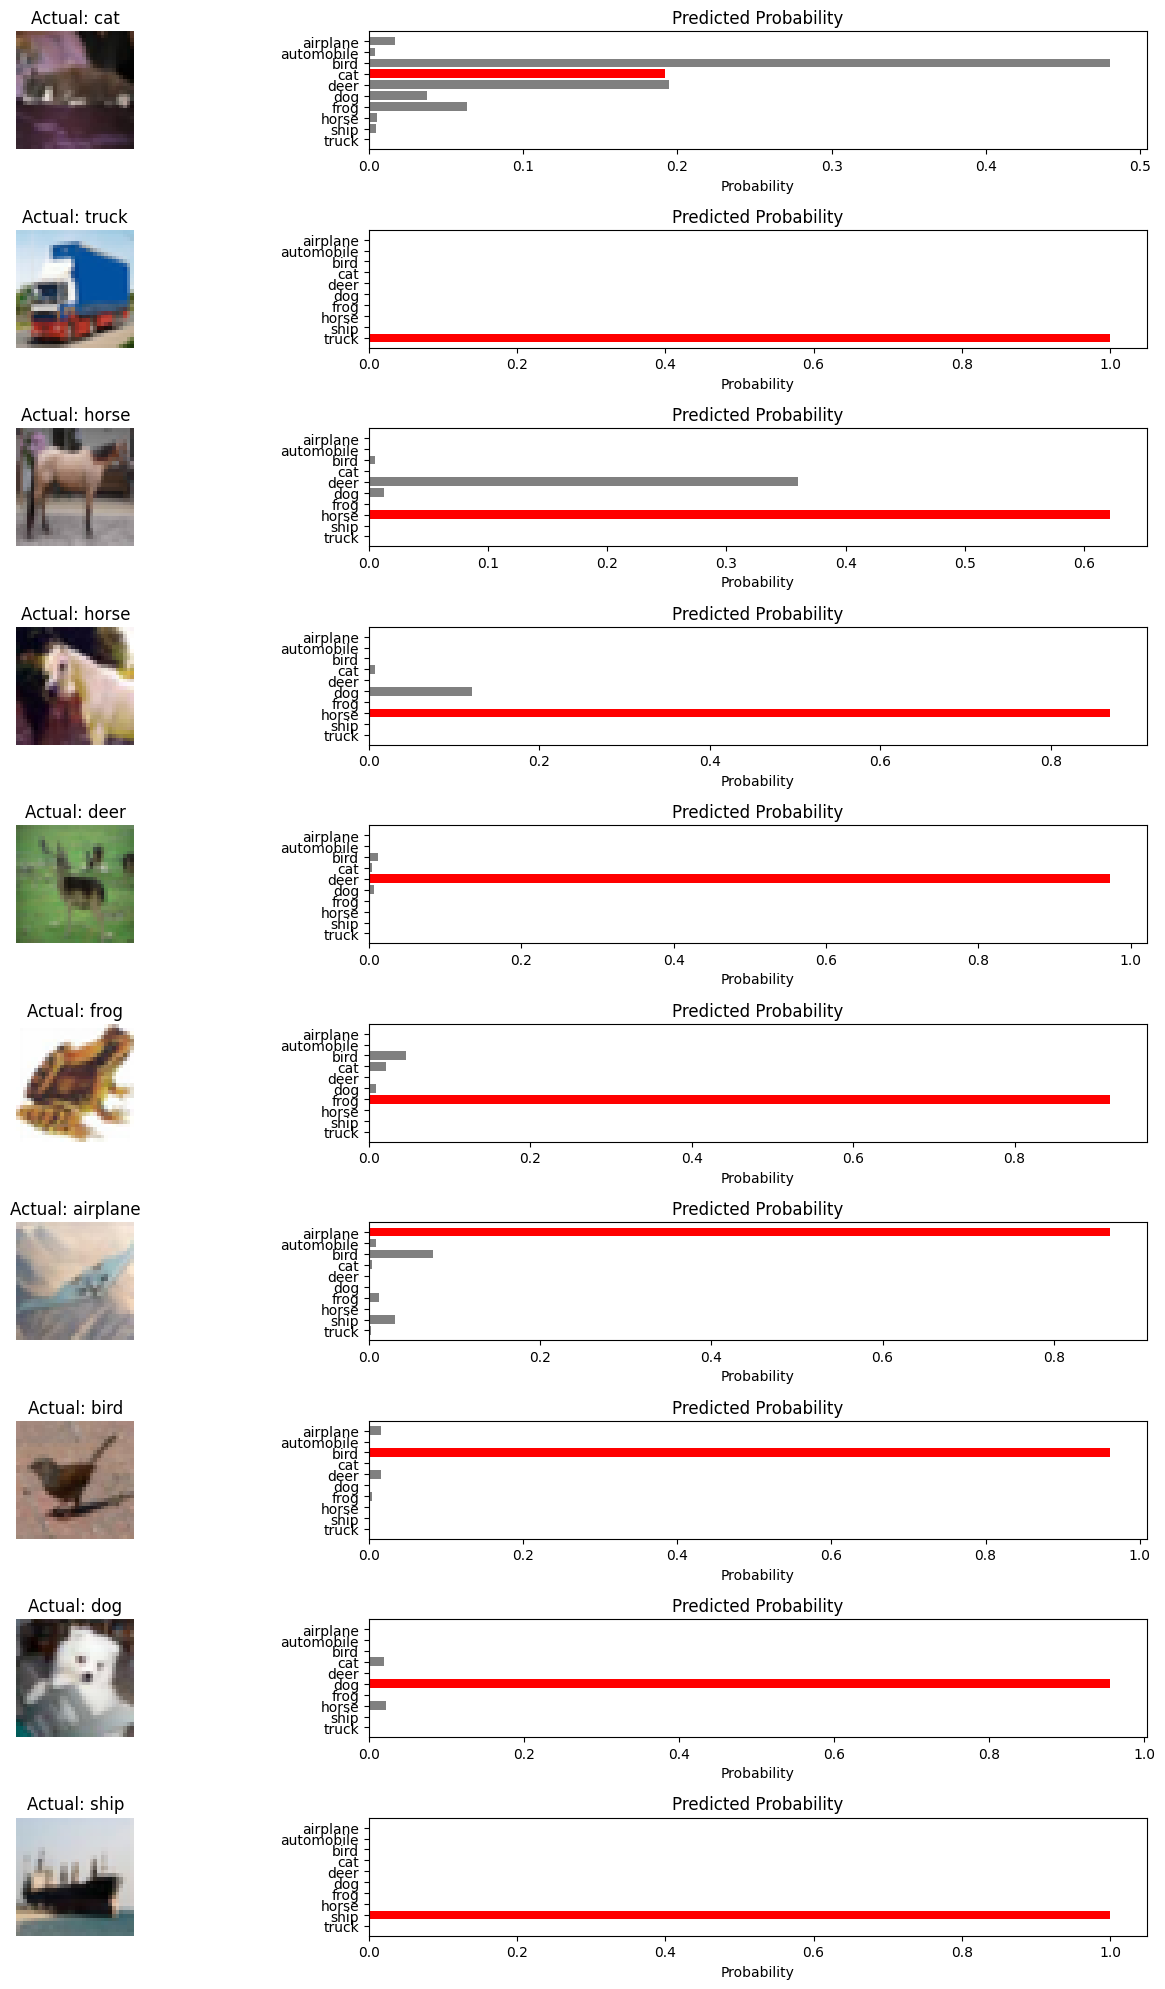

In [26]:
# Display the images along with their predicted classes and probabilities
num_images_to_display = 10
random_indices = np.random.choice(len(testset), num_images_to_display, replace=False)

# Function to get class labels from CIFAR-10 dataset
def get_class_labels():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Get class labels
class_labels = get_class_labels()


plt.figure(figsize=(15, 20))
for i, idx in enumerate(random_indices):
    image, label = testset[idx]
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to GPU if available
    output = net(image)
    probabilities = F.softmax(output, dim=1)[0]  # Compute softmax probabilities

    plt.subplot(num_images_to_display, 2, 2*i + 1)
    plt.imshow(image.squeeze().cpu().permute(1, 2, 0) * 0.5 + 0.5)  # Unnormalize and move to CPU for display
    plt.title(f'Actual: {class_labels[label]}')
    plt.axis('off')

    plt.subplot(num_images_to_display, 2, 2*i + 2)
    plt.barh(range(10), probabilities.cpu().detach().numpy(), tick_label=class_labels, color='gray')
    plt.barh(label, probabilities[label].cpu().detach().numpy(), color='red')
    plt.title('Predicted Probability')
    plt.xlabel('Probability')
    plt.gca().invert_yaxis()  # Invert y-axis to match class labels order
plt.tight_layout()
plt.show()


---
# 실습 과제 4

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.models as models


transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
targets = trainset.targets
for train_index, val_index in sss.split(np.zeros(len(targets)), targets):
    train_sampler = SubsetRandomSampler(train_index)
    val_sampler = SubsetRandomSampler(val_index)

trainloader = DataLoader(trainset, batch_size=64, sampler=train_sampler)
valloader = DataLoader(trainset, batch_size=64, sampler=val_sampler)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

100%|██████████| 170498071/170498071 [00:02<00:00, 81854571.07it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Learnable Parameters 모두 고정한 경우

In [ ]:
class Net_i(nn.Module):
    def __init__(self):
        super().__init__()

        self.resnet = models.resnet18(pretrained=True)

        for param in self.resnet.parameters():
            param.requires_grad = False


        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 10)

    def forward(self, x):
        return self.resnet(x)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net_i = Net_i().to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_i.parameters(), lr=0.001)

train_losses = []
train_accuracy = []
train_losses_iter = []
train_accuracy_iter = []
val_losses = []
val_accuracy = []


start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

for epoch in range(10):
    running_loss_iter = 0.0
    running_loss = 0.0
    correct = 0
    total = 0
    net_i.train()
    for i, data in enumerate(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net_i(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_loss_iter += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 200 == 199:
            avg_loss = running_loss_iter / 200
            accuracy = 100 * correct / total
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {avg_loss:.3f}, Accuracy: {accuracy:.2f}%')
            train_losses_iter.append(avg_loss)
            train_accuracy_iter.append(accuracy)
            running_loss_iter = 0.0
            correct = 0
            total = 0

    train_losses.append(running_loss / len(trainloader))
    train_accuracy.append(100 * correct / total)

    # Validation step
    net_i.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net_i(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses.append(val_loss / len(valloader))
    val_accuracy.append(100 * correct / total)

    print(f'Epoch {epoch+1} - Training Loss: {train_losses[-1]:.3f}, Accuracy: {train_accuracy[-1]:.2f}%, Validation Loss: {val_losses[-1]:.3f}, Accuracy: {val_accuracy[-1]:.2f}%')

print('Finished Training')

end.record()

torch.cuda.synchronize()

correct = 0
total = 0
net_i.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net_i(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10,000 test images: {test_accuracy:.2f}%')
print('------------------------')
print('Memory Usage:')
print('Max Alloc:', round(torch.cuda.max_memory_allocated(0)/1024**3, 1), 'GB')
print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')

print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')
print('Runtime:',start.elapsed_time(end))


Epoch 1, Batch 200, Loss: 1.181, Accuracy: 64.27%
Epoch 1, Batch 400, Loss: 0.763, Accuracy: 74.48%
Epoch 1, Batch 600, Loss: 0.685, Accuracy: 76.94%
Epoch 1 - Training Loss: 0.845, Accuracy: 77.11%, Validation Loss: 0.613, Accuracy: 79.48%
Epoch 2, Batch 200, Loss: 0.634, Accuracy: 78.40%
Epoch 2, Batch 400, Loss: 0.620, Accuracy: 78.83%
Epoch 2, Batch 600, Loss: 0.627, Accuracy: 78.51%
Epoch 2 - Training Loss: 0.624, Accuracy: 79.12%, Validation Loss: 0.569, Accuracy: 80.02%
Epoch 3, Batch 200, Loss: 0.592, Accuracy: 79.62%
Epoch 3, Batch 400, Loss: 0.591, Accuracy: 79.55%
Epoch 3, Batch 600, Loss: 0.598, Accuracy: 79.62%
Epoch 3 - Training Loss: 0.594, Accuracy: 79.79%, Validation Loss: 0.557, Accuracy: 80.34%
Epoch 4, Batch 200, Loss: 0.569, Accuracy: 80.11%
Epoch 4, Batch 400, Loss: 0.580, Accuracy: 79.93%
Epoch 4, Batch 600, Loss: 0.587, Accuracy: 79.48%
Epoch 4 - Training Loss: 0.581, Accuracy: 79.52%, Validation Loss: 0.580, Accuracy: 79.90%
Epoch 5, Batch 200, Loss: 0.581, Acc

```
Epoch 1, Batch 200, Loss: 1.181, Accuracy: 64.27%
Epoch 1, Batch 400, Loss: 0.763, Accuracy: 74.48%
Epoch 1, Batch 600, Loss: 0.685, Accuracy: 76.94%
Epoch 1 - Training Loss: 0.845, Accuracy: 77.11%, Validation Loss: 0.613, Accuracy: 79.48%
Epoch 2, Batch 200, Loss: 0.634, Accuracy: 78.40%
Epoch 2, Batch 400, Loss: 0.620, Accuracy: 78.83%
Epoch 2, Batch 600, Loss: 0.627, Accuracy: 78.51%
Epoch 2 - Training Loss: 0.624, Accuracy: 79.12%, Validation Loss: 0.569, Accuracy: 80.02%
Epoch 3, Batch 200, Loss: 0.592, Accuracy: 79.62%
Epoch 3, Batch 400, Loss: 0.591, Accuracy: 79.55%
Epoch 3, Batch 600, Loss: 0.598, Accuracy: 79.62%
Epoch 3 - Training Loss: 0.594, Accuracy: 79.79%, Validation Loss: 0.557, Accuracy: 80.34%
Epoch 4, Batch 200, Loss: 0.569, Accuracy: 80.11%
Epoch 4, Batch 400, Loss: 0.580, Accuracy: 79.93%
Epoch 4, Batch 600, Loss: 0.587, Accuracy: 79.48%
Epoch 4 - Training Loss: 0.581, Accuracy: 79.52%, Validation Loss: 0.580, Accuracy: 79.90%
Epoch 5, Batch 200, Loss: 0.581, Accuracy: 79.68%
Epoch 5, Batch 400, Loss: 0.563, Accuracy: 80.37%
Epoch 5, Batch 600, Loss: 0.567, Accuracy: 80.16%
Epoch 5 - Training Loss: 0.570, Accuracy: 80.42%, Validation Loss: 0.569, Accuracy: 80.36%
Epoch 6, Batch 200, Loss: 0.554, Accuracy: 80.38%
Epoch 6, Batch 400, Loss: 0.557, Accuracy: 80.54%
Epoch 6, Batch 600, Loss: 0.560, Accuracy: 80.90%
Epoch 6 - Training Loss: 0.558, Accuracy: 80.35%, Validation Loss: 0.551, Accuracy: 80.70%
Epoch 7, Batch 200, Loss: 0.552, Accuracy: 81.05%
Epoch 7, Batch 400, Loss: 0.551, Accuracy: 81.07%
Epoch 7, Batch 600, Loss: 0.560, Accuracy: 80.33%
Epoch 7 - Training Loss: 0.557, Accuracy: 80.18%, Validation Loss: 0.550, Accuracy: 80.84%
Epoch 8, Batch 200, Loss: 0.545, Accuracy: 81.14%
Epoch 8, Batch 400, Loss: 0.554, Accuracy: 80.93%
Epoch 8, Batch 600, Loss: 0.559, Accuracy: 80.50%
Epoch 8 - Training Loss: 0.555, Accuracy: 81.38%, Validation Loss: 0.554, Accuracy: 80.78%
Epoch 9, Batch 200, Loss: 0.536, Accuracy: 81.59%
Epoch 9, Batch 400, Loss: 0.549, Accuracy: 80.83%
Epoch 9, Batch 600, Loss: 0.544, Accuracy: 81.29%
Epoch 9 - Training Loss: 0.545, Accuracy: 80.91%, Validation Loss: 0.537, Accuracy: 80.42%
Epoch 10, Batch 200, Loss: 0.530, Accuracy: 81.44%
Epoch 10, Batch 400, Loss: 0.548, Accuracy: 81.03%
Epoch 10, Batch 600, Loss: 0.547, Accuracy: 80.85%
Epoch 10 - Training Loss: 0.546, Accuracy: 79.94%, Validation Loss: 0.550, Accuracy: 80.76%
Finished Training
Accuracy of the network on the 10,000 test images: 80.68%
------------------------
Memory Usage:
Max Alloc: 0.7 GB
Allocated: 0.1 GB
Cached:    1.1 GB
Runtime: 1386737.0
```

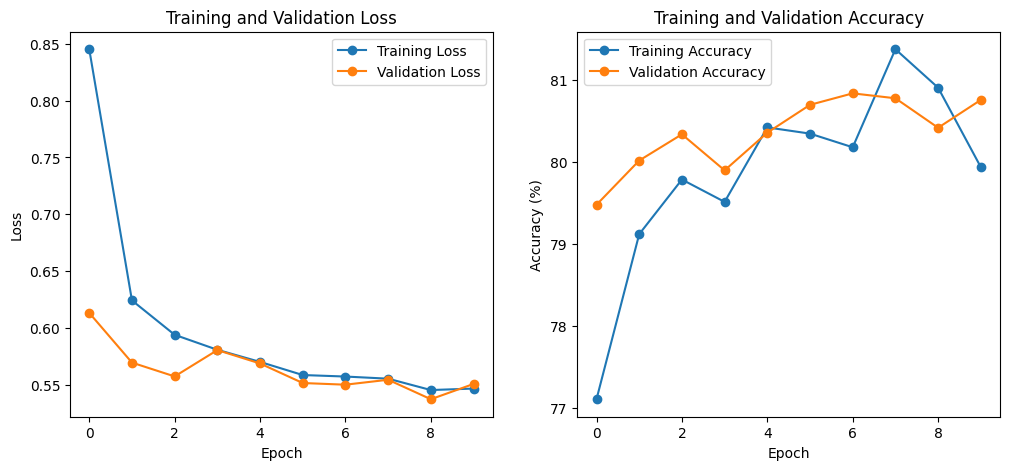

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, '-o',label='Training Loss')
plt.plot(val_losses, '-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy,  '-o',label='Training Accuracy')
plt.plot(val_accuracy, '-o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

PATH = "/content/drive/My Drive/transfer_model_i.pth"
torch.save(net_i.state_dict(), PATH)
print("Model saved successfully to Google Drive.")


Mounted at /content/drive
Model saved successfully to Google Drive.


## 마지막 3개 Layer만 제외하고 나머지 learnable parameters를 고정한 경우

In [ ]:
class Net_ii(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet18(pretrained=True)


        for name, param in self.resnet.named_parameters():
            if "layer4" not in name and "fc" not in name:
                param.requires_grad = False

        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 10)

    def forward(self, x):
        return self.resnet(x)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net_ii = Net_ii().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_ii.parameters(), lr=0.001)

train_losses = []
train_accuracy = []
train_losses_iter = []
train_accuracy_iter = []
val_losses = []
val_accuracy = []

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

for epoch in range(10):
    running_loss_iter = 0.0
    running_loss = 0.0
    correct = 0
    total = 0
    net_ii.train()
    for i, data in enumerate(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net_ii(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_loss_iter += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 200 == 199:
            avg_loss = running_loss_iter / 200
            accuracy = 100 * correct / total
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {avg_loss:.3f}, Accuracy: {accuracy:.2f}%')
            train_losses_iter.append(avg_loss)
            train_accuracy_iter.append(accuracy)
            running_loss_iter = 0.0
            correct = 0
            total = 0

    train_losses.append(running_loss / len(trainloader))
    train_accuracy.append(100 * correct / total)

    net_ii.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net_ii(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses.append(val_loss / len(valloader))
    val_accuracy.append(100 * correct / total)

    print(f'Epoch {epoch+1} - Training Loss: {train_losses[-1]:.3f}, Accuracy: {train_accuracy[-1]:.2f}%, Validation Loss: {val_losses[-1]:.3f}, Accuracy: {val_accuracy[-1]:.2f}%')

print('Finished Training')

end.record()

torch.cuda.synchronize()

correct = 0
total = 0
net_ii.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net_ii(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10,000 test images: {test_accuracy:.2f}%')
print('------------------------')
print('Memory Usage:')
print('Max Alloc:', round(torch.cuda.max_memory_allocated(0)/1024**3, 1), 'GB')
print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')
print('Runtime:',start.elapsed_time(end))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 69.9MB/s]


Epoch 1, Batch 200, Loss: 0.600, Accuracy: 79.85%
Epoch 1, Batch 400, Loss: 0.446, Accuracy: 84.97%
Epoch 1, Batch 600, Loss: 0.379, Accuracy: 87.20%
Epoch 1 - Training Loss: 0.458, Accuracy: 87.64%, Validation Loss: 0.370, Accuracy: 87.40%
Epoch 2, Batch 200, Loss: 0.213, Accuracy: 92.80%
Epoch 2, Batch 400, Loss: 0.222, Accuracy: 92.31%
Epoch 2, Batch 600, Loss: 0.225, Accuracy: 92.23%
Epoch 2 - Training Loss: 0.217, Accuracy: 92.92%, Validation Loss: 0.334, Accuracy: 89.36%
Epoch 3, Batch 200, Loss: 0.097, Accuracy: 96.55%
Epoch 3, Batch 400, Loss: 0.119, Accuracy: 95.93%
Epoch 3, Batch 600, Loss: 0.145, Accuracy: 94.85%
Epoch 3 - Training Loss: 0.125, Accuracy: 95.03%, Validation Loss: 0.344, Accuracy: 89.58%
Epoch 4, Batch 200, Loss: 0.098, Accuracy: 96.59%
Epoch 4, Batch 400, Loss: 0.078, Accuracy: 97.34%
Epoch 4, Batch 600, Loss: 0.086, Accuracy: 96.88%
Epoch 4 - Training Loss: 0.088, Accuracy: 96.76%, Validation Loss: 0.368, Accuracy: 89.90%
Epoch 5, Batch 200, Loss: 0.055, Acc

/usr/local/lib/python3.10/dist-packages/torch/cuda/memory.py:440: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


```
Epoch 1, Batch 200, Loss: 0.600, Accuracy: 79.85%
Epoch 1, Batch 400, Loss: 0.446, Accuracy: 84.97%
Epoch 1, Batch 600, Loss: 0.379, Accuracy: 87.20%
Epoch 1 - Training Loss: 0.458, Accuracy: 87.64%, Validation Loss: 0.370, Accuracy: 87.40%
Epoch 2, Batch 200, Loss: 0.213, Accuracy: 92.80%
Epoch 2, Batch 400, Loss: 0.222, Accuracy: 92.31%
Epoch 2, Batch 600, Loss: 0.225, Accuracy: 92.23%
Epoch 2 - Training Loss: 0.217, Accuracy: 92.92%, Validation Loss: 0.334, Accuracy: 89.36%
Epoch 3, Batch 200, Loss: 0.097, Accuracy: 96.55%
Epoch 3, Batch 400, Loss: 0.119, Accuracy: 95.93%
Epoch 3, Batch 600, Loss: 0.145, Accuracy: 94.85%
Epoch 3 - Training Loss: 0.125, Accuracy: 95.03%, Validation Loss: 0.344, Accuracy: 89.58%
Epoch 4, Batch 200, Loss: 0.098, Accuracy: 96.59%
Epoch 4, Batch 400, Loss: 0.078, Accuracy: 97.34%
Epoch 4, Batch 600, Loss: 0.086, Accuracy: 96.88%
Epoch 4 - Training Loss: 0.088, Accuracy: 96.76%, Validation Loss: 0.368, Accuracy: 89.90%
Epoch 5, Batch 200, Loss: 0.055, Accuracy: 98.15%
Epoch 5, Batch 400, Loss: 0.045, Accuracy: 98.55%
Epoch 5, Batch 600, Loss: 0.067, Accuracy: 97.73%
Epoch 5 - Training Loss: 0.059, Accuracy: 97.44%, Validation Loss: 0.446, Accuracy: 89.02%
Epoch 6, Batch 200, Loss: 0.052, Accuracy: 98.20%
Epoch 6, Batch 400, Loss: 0.043, Accuracy: 98.55%
Epoch 6, Batch 600, Loss: 0.060, Accuracy: 97.87%
Epoch 6 - Training Loss: 0.053, Accuracy: 97.91%, Validation Loss: 0.443, Accuracy: 89.24%
Epoch 7, Batch 200, Loss: 0.039, Accuracy: 98.73%
Epoch 7, Batch 400, Loss: 0.032, Accuracy: 98.89%
Epoch 7, Batch 600, Loss: 0.043, Accuracy: 98.55%
Epoch 7 - Training Loss: 0.041, Accuracy: 98.20%, Validation Loss: 0.448, Accuracy: 90.06%
Epoch 8, Batch 200, Loss: 0.047, Accuracy: 98.45%
Epoch 8, Batch 400, Loss: 0.036, Accuracy: 98.79%
Epoch 8, Batch 600, Loss: 0.039, Accuracy: 98.63%
Epoch 8 - Training Loss: 0.041, Accuracy: 98.68%, Validation Loss: 0.456, Accuracy: 90.62%
Epoch 9, Batch 200, Loss: 0.042, Accuracy: 98.68%
Epoch 9, Batch 400, Loss: 0.030, Accuracy: 99.05%
Epoch 9, Batch 600, Loss: 0.034, Accuracy: 98.87%
Epoch 9 - Training Loss: 0.035, Accuracy: 98.88%, Validation Loss: 0.546, Accuracy: 89.66%
Epoch 10, Batch 200, Loss: 0.032, Accuracy: 98.88%
Epoch 10, Batch 400, Loss: 0.033, Accuracy: 98.82%
Epoch 10, Batch 600, Loss: 0.039, Accuracy: 98.67%
Epoch 10 - Training Loss: 0.037, Accuracy: 98.52%, Validation Loss: 0.471, Accuracy: 90.50%
Finished Training
Accuracy of the network on the 10,000 test images: 89.81%
------------------------
Memory Usage:
Max Alloc: 0.7 GB
Allocated: 0.2 GB
Cached:    1.1 GB
Runtime: 1544303.625
```

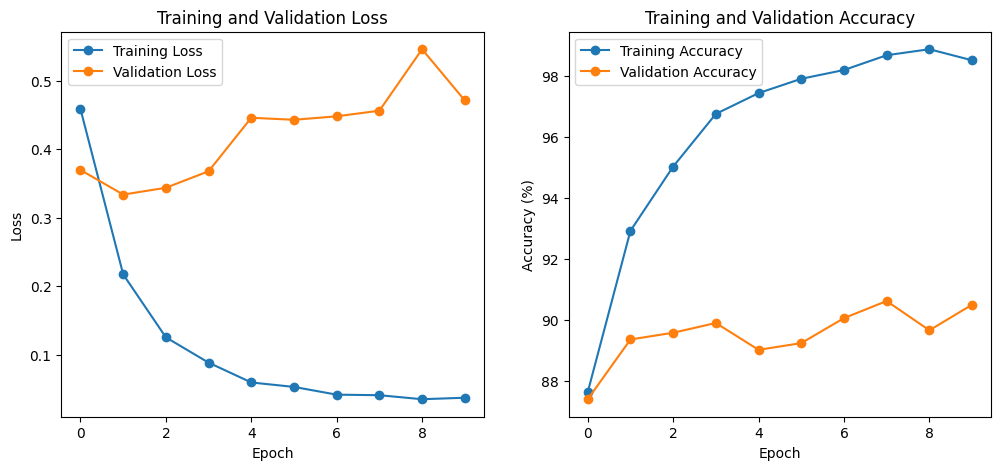

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, '-o',label='Training Loss')
plt.plot(val_losses, '-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy,  '-o',label='Training Accuracy')
plt.plot(val_accuracy, '-o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

PATH = "/content/drive/My Drive/transfer_model_ii.pth"
torch.save(net_ii.state_dict(), PATH)
print("Model saved successfully to Google Drive.")


Mounted at /content/drive
Model saved successfully to Google Drive.


## 모든 레이어를 고정하지 않은 경우

In [ ]:
class Net_iii(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet18(pretrained=True)

        for param in self.resnet.parameters():
            param.requires_grad = True

        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 10)

    def forward(self, x):
        return self.resnet(x)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net_iii = Net_iii().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_iii.parameters(), lr=0.001)

train_losses = []
train_accuracy = []
train_losses_iter = []
train_accuracy_iter = []
val_losses = []
val_accuracy = []

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

for epoch in range(10):
    running_loss_iter = 0.0
    running_loss = 0.0
    correct = 0
    total = 0
    net_iii.train()
    for i, data in enumerate(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net_iii(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_loss_iter += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 200 == 199:
            avg_loss = running_loss_iter / 200
            accuracy = 100 * correct / total
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {avg_loss:.3f}, Accuracy: {accuracy:.2f}%')
            train_losses_iter.append(avg_loss)
            train_accuracy_iter.append(accuracy)
            running_loss_iter = 0.0
            correct = 0
            total = 0

    train_losses.append(running_loss / len(trainloader))
    train_accuracy.append(100 * correct / total)

    net_iii.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net_iii(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses.append(val_loss / len(valloader))
    val_accuracy.append(100 * correct / total)

    print(f'Epoch {epoch+1} - Training Loss: {train_losses[-1]:.3f}, Accuracy: {train_accuracy[-1]:.2f}%, Validation Loss: {val_losses[-1]:.3f}, Accuracy: {val_accuracy[-1]:.2f}%')

print('Finished Training')

end.record()

torch.cuda.synchronize()

correct = 0
total = 0
net_iii.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net_iii(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10,000 test images: {test_accuracy:.2f}%')
print('------------------------')
print('Memory Usage:')
print('Max Alloc:', round(torch.cuda.max_memory_allocated(0)/1024**3, 1), 'GB')
print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')
print('Runtime:',start.elapsed_time(end))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Batch 200, Loss: 0.798, Accuracy: 72.76%
Epoch 1, Batch 400, Loss: 0.545, Accuracy: 81.50%
Epoch 1, Batch 600, Loss: 0.463, Accuracy: 84.16%
Epoch 1 - Training Loss: 0.575, Accuracy: 85.52%, Validation Loss: 0.410, Accuracy: 86.10%
Epoch 2, Batch 200, Loss: 0.335, Accuracy: 88.62%
Epoch 2, Batch 400, Loss: 0.327, Accuracy: 88.89%
Epoch 2, Batch 600, Loss: 0.319, Accuracy: 89.23%
Epoch 2 - Training Loss: 0.326, Accuracy: 89.08%, Validation Loss: 0.385, Accuracy: 87.06%
Epoch 3, Batch 200, Loss: 0.205, Accuracy: 92.82%
Epoch 3, Batch 400, Loss: 0.240, Accuracy: 91.67%
Epoch 3, Batch 600, Loss: 0.254, Accuracy: 91.13%
Epoch 3 - Training Loss: 0.234, Accuracy: 91.76%, Validation Loss: 0.311, Accuracy: 89.04%
Epoch 4, Batch 200, Loss: 0.130, Accuracy: 95.43%
Epoch 4, Batch 400, Loss: 0.153, Accuracy: 94.64%
Epoch 4, Batch 600, Loss: 0.184, Accuracy: 93.75%
Epoch 4 - Training Loss: 0.160, Accuracy: 93.52%, Validation Loss: 0.327, Accuracy: 89.52%
Epoch 5, Batch 200, Loss: 0.129, Acc

/usr/local/lib/python3.10/dist-packages/torch/cuda/memory.py:440: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


```
Epoch 1, Batch 200, Loss: 0.798, Accuracy: 72.76%
Epoch 1, Batch 400, Loss: 0.545, Accuracy: 81.50%
Epoch 1, Batch 600, Loss: 0.463, Accuracy: 84.16%
Epoch 1 - Training Loss: 0.575, Accuracy: 85.52%, Validation Loss: 0.410, Accuracy: 86.10%
Epoch 2, Batch 200, Loss: 0.335, Accuracy: 88.62%
Epoch 2, Batch 400, Loss: 0.327, Accuracy: 88.89%
Epoch 2, Batch 600, Loss: 0.319, Accuracy: 89.23%
Epoch 2 - Training Loss: 0.326, Accuracy: 89.08%, Validation Loss: 0.385, Accuracy: 87.06%
Epoch 3, Batch 200, Loss: 0.205, Accuracy: 92.82%
Epoch 3, Batch 400, Loss: 0.240, Accuracy: 91.67%
Epoch 3, Batch 600, Loss: 0.254, Accuracy: 91.13%
Epoch 3 - Training Loss: 0.234, Accuracy: 91.76%, Validation Loss: 0.311, Accuracy: 89.04%
Epoch 4, Batch 200, Loss: 0.130, Accuracy: 95.43%
Epoch 4, Batch 400, Loss: 0.153, Accuracy: 94.64%
Epoch 4, Batch 600, Loss: 0.184, Accuracy: 93.75%
Epoch 4 - Training Loss: 0.160, Accuracy: 93.52%, Validation Loss: 0.327, Accuracy: 89.52%
Epoch 5, Batch 200, Loss: 0.129, Accuracy: 95.72%
Epoch 5, Batch 400, Loss: 0.117, Accuracy: 95.97%
Epoch 5, Batch 600, Loss: 0.138, Accuracy: 95.41%
Epoch 5 - Training Loss: 0.131, Accuracy: 94.83%, Validation Loss: 0.364, Accuracy: 89.22%
Epoch 6, Batch 200, Loss: 0.085, Accuracy: 97.07%
Epoch 6, Batch 400, Loss: 0.101, Accuracy: 96.46%
Epoch 6, Batch 600, Loss: 0.114, Accuracy: 96.28%
Epoch 6 - Training Loss: 0.101, Accuracy: 96.35%, Validation Loss: 0.337, Accuracy: 90.74%
Epoch 7, Batch 200, Loss: 0.068, Accuracy: 97.72%
Epoch 7, Batch 400, Loss: 0.083, Accuracy: 96.97%
Epoch 7, Batch 600, Loss: 0.107, Accuracy: 96.16%
Epoch 7 - Training Loss: 0.089, Accuracy: 96.48%, Validation Loss: 0.389, Accuracy: 88.70%
Epoch 8, Batch 200, Loss: 0.058, Accuracy: 98.03%
Epoch 8, Batch 400, Loss: 0.066, Accuracy: 97.71%
Epoch 8, Batch 600, Loss: 0.085, Accuracy: 97.05%
Epoch 8 - Training Loss: 0.070, Accuracy: 97.39%, Validation Loss: 0.369, Accuracy: 89.94%
Epoch 9, Batch 200, Loss: 0.045, Accuracy: 98.52%
Epoch 9, Batch 400, Loss: 0.055, Accuracy: 98.09%
Epoch 9, Batch 600, Loss: 0.088, Accuracy: 97.16%
Epoch 9 - Training Loss: 0.062, Accuracy: 97.80%, Validation Loss: 0.418, Accuracy: 89.10%
Epoch 10, Batch 200, Loss: 0.048, Accuracy: 98.35%
Epoch 10, Batch 400, Loss: 0.061, Accuracy: 97.81%
Epoch 10, Batch 600, Loss: 0.053, Accuracy: 98.02%
Epoch 10 - Training Loss: 0.056, Accuracy: 97.70%, Validation Loss: 0.374, Accuracy: 90.50%
Finished Training
Accuracy of the network on the 10,000 test images: 90.14%
------------------------
Memory Usage:
Max Alloc: 1.7 GB
Allocated: 0.3 GB
Cached:    1.9 GB
Runtime: 2331152.0
```

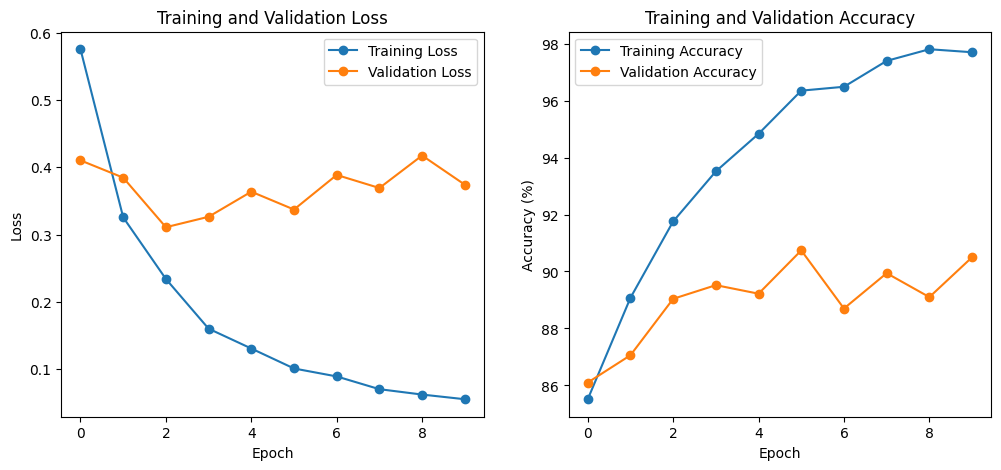

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, '-o',label='Training Loss')
plt.plot(val_losses, '-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy,  '-o',label='Training Accuracy')
plt.plot(val_accuracy, '-o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

PATH = "/content/drive/My Drive/transfer_model_iii.pth"
torch.save(net_iii.state_dict(), PATH)
print("Model saved successfully to Google Drive.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved successfully to Google Drive.


##모델 불러와서 이미지 테스트

In [ ]:
import torch
import requests

# GitHub에 저장된 모델들의 URL (raw 버전의 URL을 사용)
model_urls = [
    'https://raw.githubusercontent.com/Nick-Stokes/DLHW/main/HW2_model/transfer_model_i.pth',
    'https://raw.githubusercontent.com/Nick-Stokes/DLHW/main/HW2_model/transfer_model_ii.pth',
    'https://raw.githubusercontent.com/Nick-Stokes/DLHW/main/HW2_model/transfer_model_iii.pth'
]

# 모델 불러오기
models = []
for i, model_url in enumerate(model_urls):
    response = requests.get(model_url, stream=True)
    with open(f"model_{i}.pth", "wb") as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    model = torch.load(f"model_{i}.pth")
    models.append(model)

In [ ]:
import requests
import os
import matplotlib.pyplot as plt

# 이미지를 저장할 디렉토리 생성
os.makedirs("images", exist_ok=True)

# GitHub에 저장된 이미지 파일 URL 리스트
image_urls = [
    'https://raw.githubusercontent.com/Nick-Stokes/DLHW/main/HW2_img/img0.jpg',
    'https://raw.githubusercontent.com/Nick-Stokes/DLHW/main/HW2_img/img1.jpg',
    'https://raw.githubusercontent.com/Nick-Stokes/DLHW/main/HW2_img/img2.jpg',
    'https://raw.githubusercontent.com/Nick-Stokes/DLHW/main/HW2_img/img3.jpg',
    'https://raw.githubusercontent.com/Nick-Stokes/DLHW/main/HW2_img/img4.jpg',
    'https://raw.githubusercontent.com/Nick-Stokes/DLHW/main/HW2_img/img5.jpg',
    'https://raw.githubusercontent.com/Nick-Stokes/DLHW/main/HW2_img/img6.jpg',
    'https://raw.githubusercontent.com/Nick-Stokes/DLHW/main/HW2_img/img7.jpg',
    'https://raw.githubusercontent.com/Nick-Stokes/DLHW/main/HW2_img/img8.jpg',
    'https://raw.githubusercontent.com/Nick-Stokes/DLHW/main/HW2_img/img9.jpg'
]

# 이미지 다운로드 및 저장
for i, image_url in enumerate(image_urls):
    response = requests.get(image_url)
    with open(f"images/img{i}.jpg", "wb") as f:
        f.write(response.content)


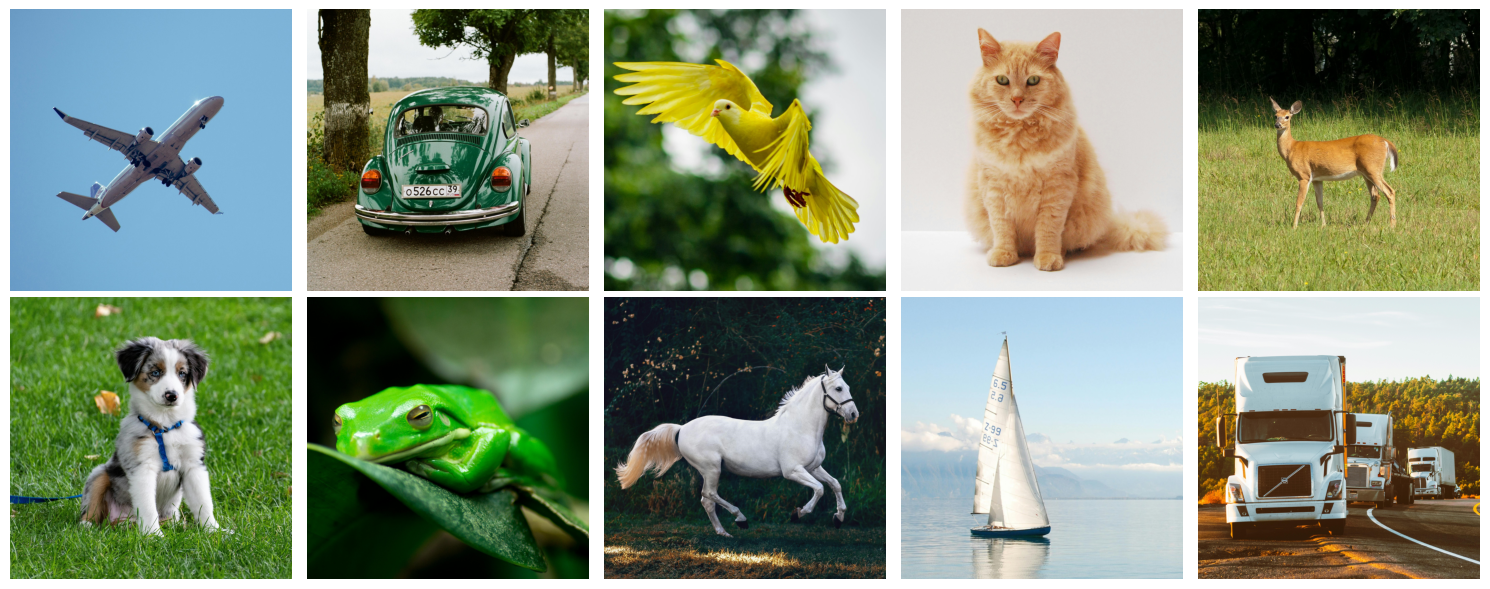

In [ ]:
# 이미지를 불러와서 imshow로 띄우기

from PIL import Image
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))

for i in range(10):
    image_path = f"images/img{i}.jpg"
    img = Image.open(image_path)

    row = i // 5
    col = i % 5
    axes[row, col].imshow(img)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

learnable parameters 모두 고정한 경우

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 141MB/s]


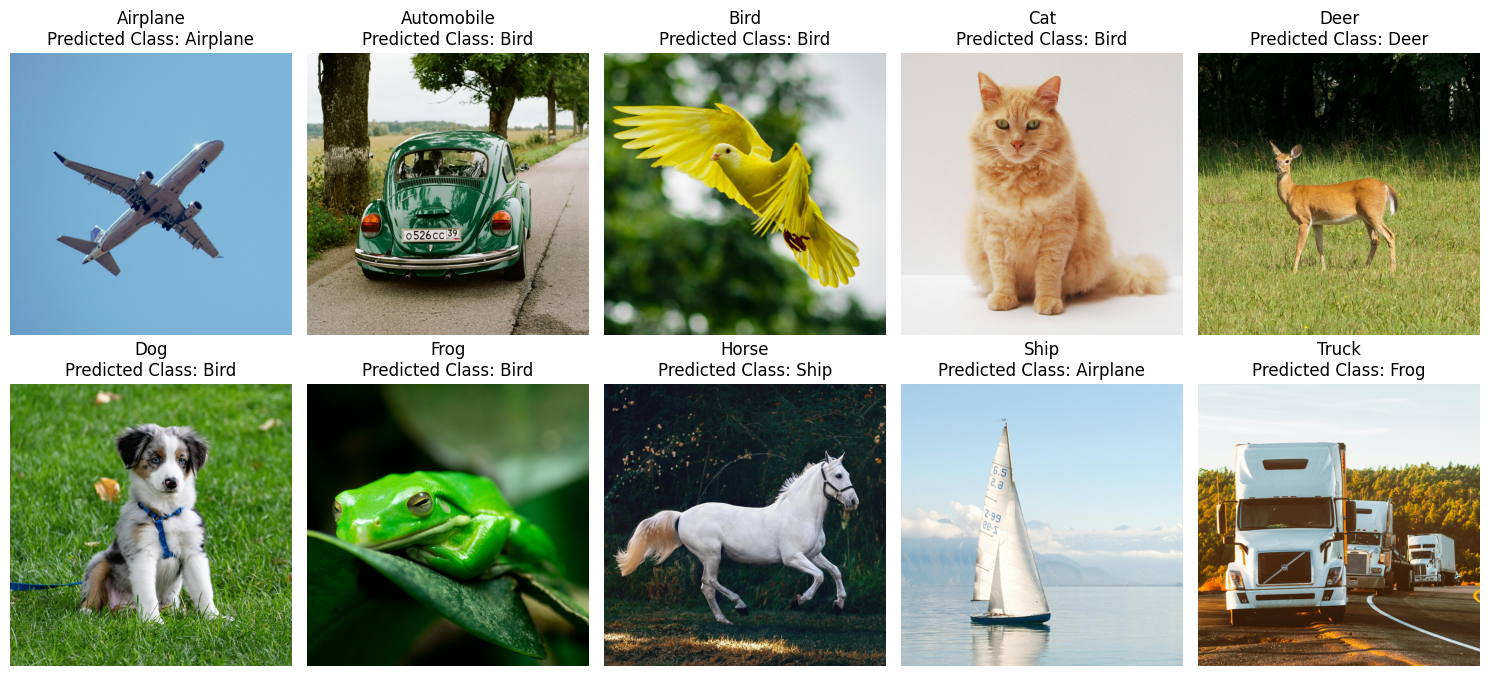

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt

# GPU 사용 가능 여부 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 모델 초기화 및 가중치 로드
model = Net_i().to(device)
model.load_state_dict(torch.load("model_0.pth", map_location=device))
model.eval()  # 평가 모드로 전환

# 이미지 전처리
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR-10 클래스 이름 리스트
classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
           'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# 이미지 파일 경로
image_paths = ["images/img0.jpg", "images/img1.jpg", "images/img2.jpg",
               "images/img3.jpg", "images/img4.jpg", "images/img5.jpg",
               "images/img6.jpg", "images/img7.jpg", "images/img8.jpg",
               "images/img9.jpg"]

# 이미지 테스트 및 결과 시각화
num_images = len(image_paths)
num_rows = 2
num_cols = 5

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 7))

for i, ax in enumerate(axes.flat):
    if i < num_images:
        # 이미지 불러오기
        image = Image.open(image_paths[i])

        # 전처리된 이미지를 모델에 입력하고 GPU로 이동
        input_image = transform(image).unsqueeze(0).to(device)

        # 예측 수행
        with torch.no_grad():
            output = model(input_image)
            _, predicted_class = output.max(1)
            predicted_class_name = classes[predicted_class.item()]

        # 결과 시각화
        ax.imshow(image)
        ax.set_title(f"{classes[i]}\nPredicted Class: {predicted_class_name}")
        ax.axis('off')

plt.tight_layout()
plt.show()


마지막 3개 layer만 제외하고 나머지 learnable paramaters 고정한 경우

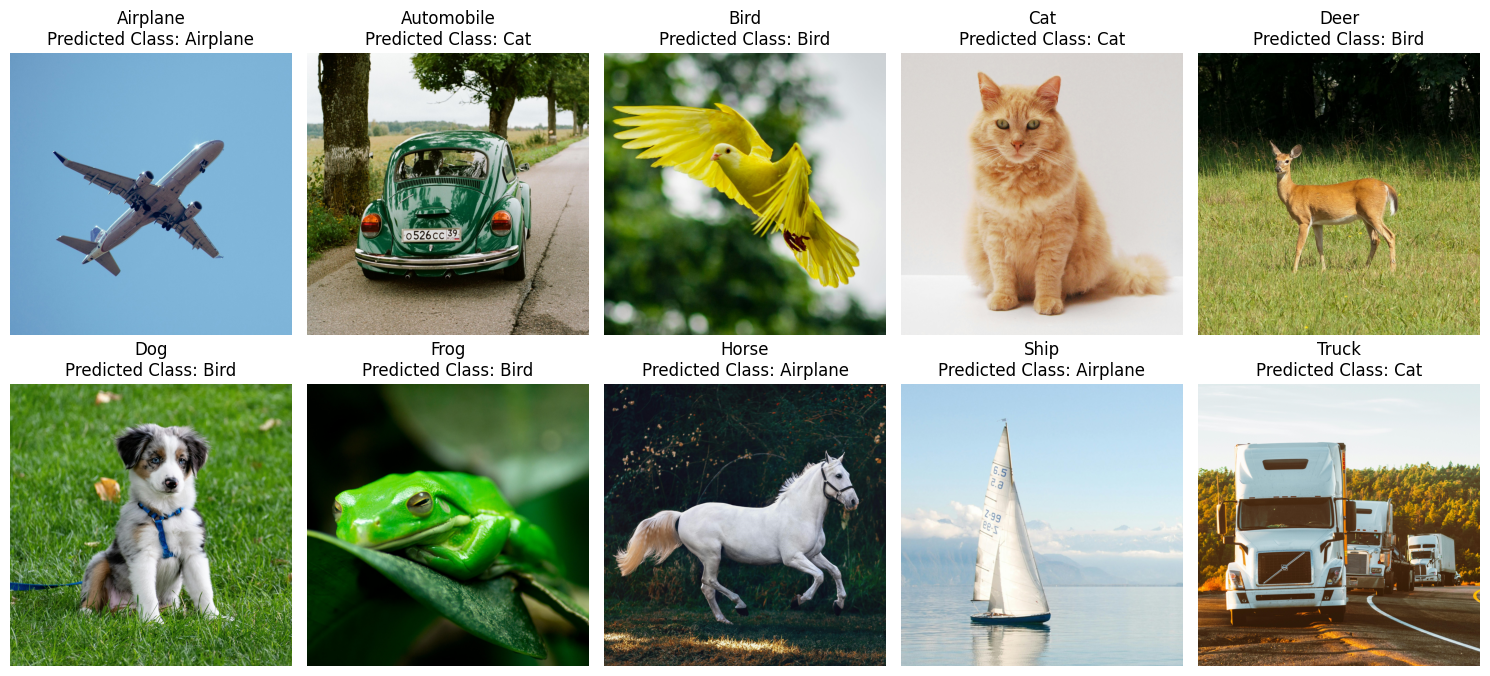

In [ ]:
# GPU 사용 가능 여부 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 모델 초기화 및 가중치 로드
model2 = Net_ii().to(device)
model2.load_state_dict(torch.load("model_1.pth", map_location=device))
model2.eval()  # 평가 모드로 전환


# 이미지 테스트 및 결과 시각화
num_images = len(image_paths)
num_rows = 2
num_cols = 5

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 7))

for i, ax in enumerate(axes.flat):
    if i < num_images:
        # 이미지 불러오기
        image = Image.open(image_paths[i])

        # 전처리된 이미지를 모델에 입력하고 GPU로 이동
        input_image = transform(image).unsqueeze(0).to(device)

        # 예측 수행
        with torch.no_grad():
            output = model2(input_image)
            _, predicted_class = output.max(1)
            predicted_class_name = classes[predicted_class.item()]

        # 결과 시각화
        ax.imshow(image)
        ax.set_title(f"{classes[i]}\nPredicted Class: {predicted_class_name}")
        ax.axis('off')

plt.tight_layout()
plt.show()

모든 layer 고정하지 않은 경우

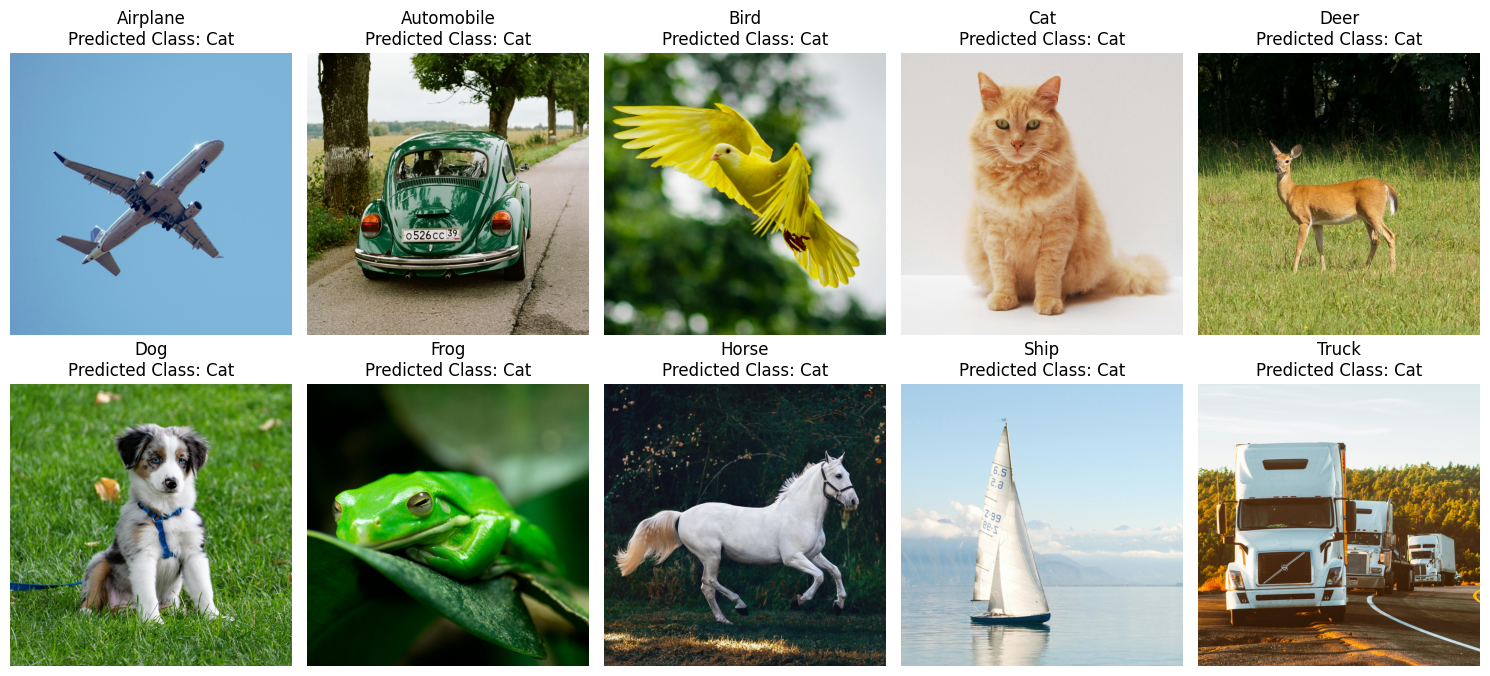

In [ ]:
# GPU 사용 가능 여부 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 모델 초기화 및 가중치 로드
model3 = Net_iii().to(device)
model3.load_state_dict(torch.load("model_2.pth", map_location=device))
model3.eval()  # 평가 모드로 전환

# 이미지 테스트 및 결과 시각화
num_images = len(image_paths)
num_rows = 2
num_cols = 5

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 7))

for i, ax in enumerate(axes.flat):
    if i < num_images:
        # 이미지 불러오기
        image = Image.open(image_paths[i])

        # 전처리된 이미지를 모델에 입력하고 GPU로 이동
        input_image = transform(image).unsqueeze(0).to(device)

        # 예측 수행
        with torch.no_grad():
            output = model3(input_image)
            _, predicted_class = output.max(1)
            predicted_class_name = classes[predicted_class.item()]

        # 결과 시각화
        ax.imshow(image)
        ax.set_title(f"{classes[i]}\nPredicted Class: {predicted_class_name}")
        ax.axis('off')

plt.tight_layout()
plt.show()